Using pre-trained image classification models from pytorch  
Fine-tuned on our reduced coco-dataset (for fair comparison)

Reference: 

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [1]:
from pycocotools.coco import COCO
import numpy as np
from pathlib import Path

from helper import print_log

In [2]:
train2017 = 'train2017'
val2017 = 'val2017'
ann_file = 'dataset/coco/annotations/instances_{}.json'

In [3]:
TOP_10_CATS_ID = set([1,  3, 62, 84, 44, 47, 67, 51, 10, 31])
CATS_NAMES = {
    1: 'person',
    3: 'car',
    62: 'chair',
    84: 'book',
    44: 'bottle',
    47: 'cup',
    67: 'dinning table',
    51: 'traffic light',
    10: 'bowl',
    31: 'handbag'
}
LABEL_LOGITS_MAPPING = {
    1: 0,
    3: 1,
    62: 2,
    84: 3,
    44: 4,
    47: 5,
    67: 6,
    51: 7,
    10: 8,
    31: 9
}
LOGITS_LABEL_MAPPING = {v:k for k, v in LABEL_LOGITS_MAPPING.items()}
LABELS = [CATS_NAMES[k] for k in LABEL_LOGITS_MAPPING.keys()]

In [4]:
coco_train = COCO(ann_file.format(train2017))
coco_val = COCO(ann_file.format(val2017))

loading annotations into memory...
Done (t=7.40s)
creating index...
index created!
loading annotations into memory...
Done (t=0.23s)
creating index...
index created!


In [5]:
def get_coco_images_and_labels(coco):

    # get all filenames
    img_ids_w_filename = {coco.dataset['images'][i]['id']: coco.dataset['images'][i]['file_name'] for i in range(len(coco.dataset['images']))}      # use dictionary for faster query

    # get all images
    img_ids = [coco.dataset['images'][i]['id'] for i in range(len(coco.dataset['images']))]

    # load labels for each imgs (as one img may have multiple labels)
    labels_per_imgs = []
    for i in range(len(img_ids)):
        labels_per_imgs.append(coco.loadAnns(coco.getAnnIds(imgIds=img_ids[i])))

    img_id_w_bb = []
    label_per_obj = []

    for labels in labels_per_imgs:
        for l in labels:
            img_id_w_bb.append((l['id'], l['image_id'], l['bbox']))
            label_per_obj.append(l['category_id'])

    return img_ids_w_filename, img_id_w_bb, label_per_obj

In [6]:
img_ids_w_filename_train, img_id_w_bb_train, label_per_obj_train = get_coco_images_and_labels(coco_train)
img_ids_w_filename_val, img_id_w_bb_val, label_per_obj_val = get_coco_images_and_labels(coco_val)

---

Dataset save/load

In [7]:
# load filtered dataset

import pickle

filtered_dataset_dir = Path('dataset/coco_top10_filtered_20250423')

with open(filtered_dataset_dir / 'img_id_w_bb_train_top10_v2.pkl', 'rb') as f:
    img_id_w_bb_train_top10_filtered = pickle.load(f)
with open(filtered_dataset_dir / 'label_per_obj_train_top10_v2.pkl', 'rb') as f:
    label_per_obj_train_top10_filtered = pickle.load(f)

with open(filtered_dataset_dir/ 'img_id_w_bb_val_top10.pkl', 'rb') as f:
    img_id_w_bb_val_top10 = pickle.load(f)
with open(filtered_dataset_dir / 'label_per_obj_val_top10.pkl', 'rb') as f:
    label_per_obj_val_top10 = pickle.load(f)

In [8]:
img_id_w_bb_train[0]

(151091, 391895, [359.17, 146.17, 112.45, 213.57])

In [9]:
len(img_id_w_bb_train_top10_filtered), len(label_per_obj_train_top10_filtered), len(img_id_w_bb_val_top10), len(label_per_obj_val_top10)

(62444, 62444, 20312, 20312)

In [10]:
# convert labels to logits
label_per_obj_train_top10_filtered_logits = np.array([LABEL_LOGITS_MAPPING[l] for l in label_per_obj_train_top10_filtered], dtype=np.int32)
label_per_obj_val_top10_logits = np.array([LABEL_LOGITS_MAPPING[l] for l in label_per_obj_val_top10], dtype=np.int32)

In [11]:
label_per_obj_train_top10_filtered[:20]

[44, 44, 44, 44, 51, 44, 44, 44, 44, 44, 44, 1, 1, 51, 47, 44, 47, 47, 47, 47]

In [12]:
label_per_obj_train_top10_filtered_logits[:20]

array([4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 0, 0, 7, 5, 4, 5, 5, 5, 5],
      dtype=int32)

---

Create train-val-test set

Note that the split will be slightly different, due to the different strategy in handling images-to-bbox relationship

In [13]:
import torch
from torchvision.transforms import v2 as T
from torchvision.io import read_image

import math

class ReducedCOCODataset(torch.utils.data.Dataset):
    def __init__(self, img_id_w_bb:list, label_per_obj:list, img_ids_w_filename, coco_ds_name:str, transforms):
        self.img_id_w_bb = img_id_w_bb
        self.label_per_obj = label_per_obj
        self.img_ids_w_filename = img_ids_w_filename
        self.coco_ds_name = coco_ds_name
        self.transforms = transforms
        self.labels = LABELS

        self._def_transform = self._default_transforms()

        assert self.coco_ds_name in ['train2017', 'val2017'], f"Invalid coco dataset name: {self.coco_ds_name}"

    def __getitem__(self, idx):
        # get the image id
        ann_id, img_id, bbox = self.img_id_w_bb[idx]
        label = self.label_per_obj[idx]

        # load image
        img_name = self.img_ids_w_filename[img_id]
        img_path = Path(f"dataset/coco/{self.coco_ds_name}/{img_name}")
        img = read_image(img_path)

        # chop the image to the bbox
        x1, y1, w, h = bbox
        x1 = int(math.floor(x1))
        y1 = int(math.floor(y1))
        x2 = int(math.floor(x1 + w)) + 1
        y2 = int(math.floor(y1 + h)) + 1
        img = img[:, y1:y2, x1:x2]
        

        # any data augmentation (?)

        # apply transforms
        img_t, label = self._def_transform(img, label)

        return img_t, label
    
    def get_details_from_id(self, idx):
        ann_id, img_id, bbox = self.img_id_w_bb[idx]
        label = self.label_per_obj[idx]

        # load image
        img_name = self.img_ids_w_filename[img_id]
        img_path = Path(f"dataset/coco/{self.coco_ds_name}/{img_name}")
        img = read_image(img_path)       

        return img_path, img, bbox, label
    
    def _default_transforms(self):
        transforms = []
        transforms.append(T.Resize((224, 224)))
        transforms.append(T.ToDtype(torch.float, scale=True))
        transforms.append(T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
        transforms.append(T.ToPureTensor())
        return T.Compose(transforms)
    
    def __len__(self):
        return len(self.img_id_w_bb)
        

In [14]:
# check dataset
dataset_traintest = ReducedCOCODataset(
    img_id_w_bb_train_top10_filtered,
    label_per_obj_train_top10_filtered_logits,
    img_ids_w_filename_train,
    coco_ds_name='train2017',
    transforms=None
)
print('length of dataset = ', len(dataset_traintest), '\n')

length of dataset =  62444 



In [15]:
dataset_traintest.labels, len(dataset_traintest.labels)

(['person',
  'car',
  'chair',
  'book',
  'bottle',
  'cup',
  'dinning table',
  'traffic light',
  'bowl',
  'handbag'],
 10)

In [16]:
# validation set

dataset_val = ReducedCOCODataset(
    img_id_w_bb_val_top10,
    label_per_obj_val_top10_logits,
    img_ids_w_filename_val,
    coco_ds_name='val2017',
    transforms=None
)
print('length of dataset = ', len(dataset_val), '\n')
# getting the image and target of the dataset
img, target = dataset_val[1]
print(img, '\n',target)

length of dataset =  20312 

tensor([[[-1.7240, -1.6555, -1.6213,  ..., -0.7993, -1.3473, -1.9467],
         [-1.7069, -1.6898, -1.6555,  ..., -0.8164, -1.3302, -1.9295],
         [-1.7240, -1.7240, -1.6898,  ..., -0.7822, -1.3130, -1.9467],
         ...,
         [ 0.2967,  0.2796,  0.2796,  ..., -0.5424, -0.6109, -0.7137],
         [ 0.3138,  0.2967,  0.2967,  ..., -0.5082, -0.5767, -0.6794],
         [ 0.3309,  0.3309,  0.3138,  ..., -0.4054, -0.5082, -0.5938]],

        [[-1.8256, -1.7556, -1.7031,  ..., -1.1604, -1.5280, -1.8606],
         [-1.8081, -1.7906, -1.7206,  ..., -1.1253, -1.4930, -1.8256],
         [-1.8081, -1.8081, -1.7206,  ..., -1.1429, -1.4755, -1.8081],
         ...,
         [-0.1625, -0.1625, -0.1625,  ..., -0.9503, -1.0203, -1.1429],
         [-0.1450, -0.1450, -0.1450,  ..., -0.8978, -0.9678, -1.0728],
         [-0.1099, -0.1099, -0.1099,  ..., -0.7927, -0.8978, -0.9853]],

        [[-1.5081, -1.3861, -1.3164,  ..., -0.9853, -1.2990, -1.6476],
         [-1.508

In [17]:
len(img_id_w_bb_val)

36781

In [18]:
len(label_per_obj_val_top10_logits)

20312

---

Model initialization

In [19]:
# build models

# from torchvision.models import efficientnet_v2_m
from torchvision.models import efficientnet_b0

MODEL_NAME = 'EfficientNet-B0'      # CHANGE HERE AS WELL WHILE CHANGING THE MODELS

class FINETUNING_STRATEGY:
    WHOLE_NETWORK = 'finetune'
    FEATURE_EXTRACTOR = 'featextract'

    def __str__(self):
        return self.value

def init_model(finetuning_strategy:FINETUNING_STRATEGY, out_features:int):
    # using mobile net for faster training, while have decent accuracy
    model = efficientnet_b0(weights='DEFAULT')

    if finetuning_strategy == FINETUNING_STRATEGY.FEATURE_EXTRACTOR:
        # freeze all layers
        for param in model.parameters():
            param.requires_grad = False

        # except the last layer
        model.classifier[-1] = torch.nn.Linear(in_features=1280, out_features=out_features)
        model.classifier[-1].requires_grad = True
        
    elif finetuning_strategy == FINETUNING_STRATEGY.WHOLE_NETWORK:
        model.classifier[-1] = torch.nn.Linear(in_features=1280, out_features=out_features)

        for param in model.parameters():
            param.requires_grad = True


    return model

In [20]:
FINETUNING_STRAT = FINETUNING_STRATEGY.FEATURE_EXTRACTOR
model = init_model(FINETUNING_STRAT, len(LABELS))

In [21]:
from torchinfo import summary

summary(model, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], depth=4)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [1, 3, 224, 224]          [1, 10]                   --                        Partial
├─Sequential: 1-1                                       [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        False
│    └─Conv2dNormActivation: 2-1                        [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─Sequential

---

Training loop with hyperparameter selection

we are looking for 
- batch size (16, 32)
- learning rate (5e-4, 1e-4, 5e-5)
- n epoch (2, 3, 4)

Total combinations: $2 \times 3 \times 3 = 18$

In [22]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [23]:
from itertools import product

BATCH_SIZE_GRID = [16, 32, 64]
LR_GRID = [1e-4, 5e-5, 1e-5]

MAX_EPOCHES = 15

hyperparam_combs = list(product(BATCH_SIZE_GRID, LR_GRID))
print('Total number of hyperparameter combinations: ', len(hyperparam_combs))

Total number of hyperparameter combinations:  9


In [24]:
from datetime import datetime

tdy = datetime.now()
top_model_dir = Path(f'models/{MODEL_NAME}-{FINETUNING_STRAT}/{tdy.strftime("%Y%m%d-%H%M%S")}/')
if not top_model_dir.exists():
    top_model_dir.mkdir(parents=True)

In [25]:
from sklearn.model_selection import train_test_split

# create train and validation set
train_indices, test_indices = train_test_split(list(range(len(dataset_traintest.img_id_w_bb))), test_size=0.2, random_state=42)

dataset_train = torch.utils.data.Subset(dataset_traintest, train_indices)
dataset_test = torch.utils.data.Subset(dataset_traintest, test_indices)

In [26]:
def collate_fn(batch):
  return tuple(zip(*batch))

def build_data_loaders(batch_size):
    data_loader_train = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        collate_fn=collate_fn,
    )

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn,
    )

    data_loader_valid = torch.utils.data.DataLoader(
        dataset_val,
        batch_size=16,      # fixed for inference
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn,
    )

    return data_loader_train, data_loader_test, data_loader_valid

In [27]:
from tqdm import tqdm
import matplotlib.pyplot as plt

'''
Function to train the model over one epoch.
'''
def train_one_epoch(model, criterion, optimizer, data_loader):
  
    train_loss = 0.0
    train_corrects = 0

    labels_list = []
    preds_list = []

    tqdm_bar = tqdm(data_loader, total=len(data_loader))
    for idx, data in enumerate(tqdm_bar):
        inputs, labels = data

        optimizer.zero_grad()

        # forward pass
        inputs = torch.stack(inputs, dim=0).to(DEVICE)
        labels = torch.tensor(labels, dtype=torch.float64).type(torch.LongTensor).to(DEVICE)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_val = loss.item()
        train_loss += loss_val
        train_corrects += (preds == labels).sum().item()

        labels_list.append(labels)
        preds_list.append(preds)
        
        tqdm_bar.set_description(desc=f"Training Loss: {loss_val:.3f}")

    train_loss /= len(data_loader)
    acc = float(train_corrects) / len(data_loader.dataset)
    labels_list = torch.cat(labels_list).cpu().numpy()
    preds_list = torch.cat(preds_list).cpu().numpy()
    print_log(f"Avg training Loss: {train_loss:.3f}; Accuracy: {acc:.3f}")

    return train_loss, acc, labels_list, preds_list

In [28]:
def evaluate(model, criterion, data_loader):
    test_loss = 0.0
    test_corrects = 0

    labels_list = []
    preds_list = []

    tqdm_bar = tqdm(data_loader, total=len(data_loader))

    for i, data in enumerate(tqdm_bar):
        inputs, labels = data

        inputs = torch.stack(inputs, dim=0).to(DEVICE)
        labels = torch.tensor(labels, dtype=torch.float64).type(torch.LongTensor).to(DEVICE)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            

        loss_val = loss.item()
        test_loss += loss_val
        test_corrects += (preds == labels).sum().item()

        labels_list.append(labels)
        preds_list.append(preds)

        tqdm_bar.set_description(desc=f"Testing Loss: {loss_val:.4f}")

    labels_list = torch.cat(labels_list).cpu().numpy()
    preds_list = torch.cat(preds_list).cpu().numpy()
    test_loss /= len(data_loader)
    acc = float(test_corrects) / len(data_loader.dataset)
    print_log(f"Avg testing Loss: {test_loss:.3f}; Accuracy: {acc:.3f}")
    
    return test_loss, acc, labels_list, preds_list

In [29]:
def evaluation_pred(model, data_loader, stage:str):
    
    labels_list = []
    preds_list =[]

    model.eval()
    
    tqdm_bar = tqdm(data_loader, total=len(data_loader))
    for i, data in enumerate(tqdm_bar):
        inputs, labels = data

        images = torch.stack(inputs, dim=0).to(DEVICE)
        labels = torch.tensor(labels, dtype=torch.float64).type(torch.LongTensor).to(DEVICE)

        with torch.no_grad():
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

        labels_list.append(labels)
        preds_list.append(preds)

        tqdm_bar.set_description(f"Evaluating {stage}")

    labels_list = torch.cat(labels_list).cpu().numpy()
    preds_list = torch.cat(preds_list).cpu().numpy()
    
    return labels_list, preds_list

In [30]:
# compute acc, confusion matrix, classification report

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

def compute_accuracy(y_true, y_pred):
    """Compute accuracy score"""
    return accuracy_score(y_true, y_pred)

def compute_classification_report(y_true, y_pred, labels):
    """Compute classification report"""
    return classification_report(y_true, y_pred, target_names=labels, zero_division=0)

def compute_confusion_matrix(y_true, y_pred, labels, save=False, save_path=None):
    """Compute confusion matrix"""
    cm_matrix = confusion_matrix(y_true, y_pred)

    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm_matrix, display_labels=labels)
    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_title('Confusion Matrix')
    cm_disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=90)

    if save:
        if save_path is None:
            raise ValueError("save_path must be provided if save is True")
        plt.savefig(save_path)

def compute_classification_metrics(target_labels, pred_labels, target_names:list[str]):
    
    # compute accuracy
    acc = compute_accuracy(target_labels, pred_labels)
    print("Accuracy: ", acc)

    report = compute_classification_report(target_labels, pred_labels, target_names)
    print("Classification Report:\n", report)

    # compute confusion matrix
    compute_confusion_matrix(target_labels, pred_labels, target_names, save=False)

    return target_labels, pred_labels

def save_evaluations(y, y_pred, labels, model_dir, eval_stage=str):
    """Save the evaluation results
    
    eval_stage: str
        The stage of the evaluation. It can be 'train', 'test' or 'val.
    """
    # Save the accuracy score
    accuracy = compute_accuracy(y, y_pred)
    print(f"Accuracy [{eval_stage}]: {accuracy}")

    # Save the classification report
    report = compute_classification_report(y, y_pred, labels)
    with open(model_dir / f'classification_report_{eval_stage}.txt', 'w') as f:
        f.write(report)

    # Save the confusion matrix
    cm_path = model_dir / f'confusion_matrix_{eval_stage}.png'
    compute_confusion_matrix(y, y_pred, labels, save=True, save_path=cm_path)

In [31]:
# define early stopper -> w/out the need to test epoch; just need to define the patience
# and maximum epoches for the model

class EarlyStopper:
    """A handy early stopper to stop the training process when the validation loss
    does not improve for a certain number of epochs (patience)."""

    def __init__(self, patience=5, delta=0, minimize=True):
        """
        Args:
            patience (int): Number of epochs with no improvement after which training will be stopped.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            minimize (bool): Whether to minimize or maximize the monitored quantity.
        """
        self.patience = patience
        self.delta = delta
        self.minimize = minimize    # define if the loss (quantity to be monitored) is minimized or maximized
        
        self.counter = 0
        self.best_loss = None       # the quantity to be monitored
        
        self.best_epoch = -1
        self.best_model = None

    def step(self, loss, curr_epoch, model):
        if self.best_loss is None:
            self.best_loss = loss
            self.counter = 0
            self.best_epoch = curr_epoch
            self.best_model = model

        # check if the loss improved
        elif self.minimize and loss < self.best_loss - self.delta:
            self.best_loss = loss
            self.counter = 0
            self.best_epoch = curr_epoch
            self.best_model = model
        elif not self.minimize and loss > self.best_loss + self.delta:
            self.best_loss = loss
            self.counter = 0
            self.best_epoch = curr_epoch
            self.best_model = model
        else:
            self.counter += 1

        return self.counter >= self.patience
    
    def get_best_model(self):
        return self.best_model

[2025-04-24 17:12:27:582] - --------------------------------------------------
[2025-04-24 17:12:27:582] - Batch size: 16, Learning rate: 0.0001
[2025-04-24 17:12:27:582] - --------------------------------------------------
[2025-04-24 17:12:27:583] - Model directory models/EfficientNet-B0-featextract/20250424-171226/bs_16_lr_0.0001 created
[2025-04-24 17:12:27:672] - Epoch 1/15


Training Loss: 1.588: 100%|██████████| 3123/3123 [00:51<00:00, 60.32it/s]


[2025-04-24 17:13:19:453] - Avg training Loss: 1.429; Accuracy: 0.553


Testing Loss: 1.5401: 100%|██████████| 781/781 [00:12<00:00, 64.66it/s]


[2025-04-24 17:13:31:536] - Avg testing Loss: 1.115; Accuracy: 0.675
[2025-04-24 17:13:31:538] - Epoch 2/15


Training Loss: 1.758: 100%|██████████| 3123/3123 [00:51<00:00, 60.88it/s]


[2025-04-24 17:14:22:841] - Avg training Loss: 1.116; Accuracy: 0.649


Testing Loss: 1.5800: 100%|██████████| 781/781 [00:11<00:00, 66.46it/s]


[2025-04-24 17:14:34:597] - Avg testing Loss: 0.995; Accuracy: 0.691
[2025-04-24 17:14:34:598] - Epoch 3/15


Training Loss: 1.750: 100%|██████████| 3123/3123 [00:51<00:00, 60.61it/s]


[2025-04-24 17:15:26:134] - Avg training Loss: 1.051; Accuracy: 0.659


Testing Loss: 1.3245: 100%|██████████| 781/781 [00:11<00:00, 65.60it/s]


[2025-04-24 17:15:38:044] - Avg testing Loss: 0.944; Accuracy: 0.704
[2025-04-24 17:15:38:045] - Epoch 4/15


Training Loss: 1.361: 100%|██████████| 3123/3123 [00:51<00:00, 60.39it/s]


[2025-04-24 17:16:29:770] - Avg training Loss: 1.021; Accuracy: 0.669


Testing Loss: 1.4578: 100%|██████████| 781/781 [00:11<00:00, 65.20it/s]


[2025-04-24 17:16:41:754] - Avg testing Loss: 0.946; Accuracy: 0.702
[2025-04-24 17:16:41:755] - Epoch 5/15


Training Loss: 0.691: 100%|██████████| 3123/3123 [00:51<00:00, 60.62it/s]


[2025-04-24 17:17:33:282] - Avg training Loss: 1.001; Accuracy: 0.674


Testing Loss: 1.3642: 100%|██████████| 781/781 [00:11<00:00, 65.36it/s]


[2025-04-24 17:17:45:236] - Avg testing Loss: 0.901; Accuracy: 0.716
[2025-04-24 17:17:45:237] - Epoch 6/15


Training Loss: 1.937: 100%|██████████| 3123/3123 [00:52<00:00, 59.25it/s]


[2025-04-24 17:18:37:951] - Avg training Loss: 0.990; Accuracy: 0.676


Testing Loss: 1.2829: 100%|██████████| 781/781 [00:11<00:00, 65.46it/s]


[2025-04-24 17:18:49:886] - Avg testing Loss: 0.890; Accuracy: 0.722
[2025-04-24 17:18:49:887] - Epoch 7/15


Training Loss: 1.876: 100%|██████████| 3123/3123 [00:51<00:00, 60.63it/s]


[2025-04-24 17:19:41:402] - Avg training Loss: 0.974; Accuracy: 0.682


Testing Loss: 1.2297: 100%|██████████| 781/781 [00:12<00:00, 64.47it/s]


[2025-04-24 17:19:53:521] - Avg testing Loss: 0.869; Accuracy: 0.726
[2025-04-24 17:19:53:522] - Epoch 8/15


Training Loss: 1.404: 100%|██████████| 3123/3123 [00:51<00:00, 60.41it/s]


[2025-04-24 17:20:45:224] - Avg training Loss: 0.970; Accuracy: 0.683


Testing Loss: 1.3950: 100%|██████████| 781/781 [00:11<00:00, 65.58it/s]


[2025-04-24 17:20:57:139] - Avg testing Loss: 0.860; Accuracy: 0.727
[2025-04-24 17:20:57:140] - Epoch 9/15


Training Loss: 0.797: 100%|██████████| 3123/3123 [00:52<00:00, 59.94it/s]


[2025-04-24 17:21:49:251] - Avg training Loss: 0.960; Accuracy: 0.683


Testing Loss: 1.2501: 100%|██████████| 781/781 [00:11<00:00, 65.28it/s]


[2025-04-24 17:22:01:219] - Avg testing Loss: 0.869; Accuracy: 0.720
[2025-04-24 17:22:01:220] - Epoch 10/15


Training Loss: 2.704: 100%|██████████| 3123/3123 [00:51<00:00, 60.83it/s]


[2025-04-24 17:22:52:566] - Avg training Loss: 0.958; Accuracy: 0.688


Testing Loss: 1.2272: 100%|██████████| 781/781 [00:12<00:00, 64.88it/s]


[2025-04-24 17:23:04:608] - Avg testing Loss: 0.857; Accuracy: 0.731
[2025-04-24 17:23:04:609] - Epoch 11/15


Training Loss: 1.304: 100%|██████████| 3123/3123 [00:51<00:00, 60.15it/s]


[2025-04-24 17:23:56:532] - Avg training Loss: 0.958; Accuracy: 0.685


Testing Loss: 1.1654: 100%|██████████| 781/781 [00:11<00:00, 65.72it/s]


[2025-04-24 17:24:08:420] - Avg testing Loss: 0.867; Accuracy: 0.721
[2025-04-24 17:24:08:421] - Epoch 12/15


Training Loss: 0.953: 100%|██████████| 3123/3123 [00:51<00:00, 60.56it/s]


[2025-04-24 17:25:00:001] - Avg training Loss: 0.955; Accuracy: 0.685


Testing Loss: 1.3974: 100%|██████████| 781/781 [00:11<00:00, 65.18it/s]


[2025-04-24 17:25:11:988] - Avg testing Loss: 0.844; Accuracy: 0.731
[2025-04-24 17:25:11:989] - Epoch 13/15


Training Loss: 1.339: 100%|██████████| 3123/3123 [00:51<00:00, 60.55it/s]


[2025-04-24 17:26:03:569] - Avg training Loss: 0.946; Accuracy: 0.687


Testing Loss: 1.2588: 100%|██████████| 781/781 [00:11<00:00, 65.76it/s]


[2025-04-24 17:26:15:450] - Avg testing Loss: 0.861; Accuracy: 0.725
[2025-04-24 17:26:15:451] - Epoch 14/15


Training Loss: 1.476: 100%|██████████| 3123/3123 [00:51<00:00, 60.62it/s]


[2025-04-24 17:27:06:973] - Avg training Loss: 0.951; Accuracy: 0.685


Testing Loss: 1.5621: 100%|██████████| 781/781 [00:11<00:00, 65.66it/s]


[2025-04-24 17:27:18:872] - Avg testing Loss: 0.847; Accuracy: 0.725
[2025-04-24 17:27:18:873] - Epoch 15/15


Training Loss: 0.744: 100%|██████████| 3123/3123 [00:51<00:00, 60.41it/s]


[2025-04-24 17:28:10:575] - Avg training Loss: 0.941; Accuracy: 0.692


Testing Loss: 1.2571: 100%|██████████| 781/781 [00:11<00:00, 65.68it/s]


[2025-04-24 17:28:22:470] - Avg testing Loss: 0.835; Accuracy: 0.731
[2025-04-24 17:28:22:471] - Early stopping at epoch 15
[2025-04-24 17:28:22:471] - Best epoch: 10; Best Acc: 0.731
[2025-04-24 17:28:22:507] - Model saved to models/EfficientNet-B0-featextract/20250424-171226/bs_16_lr_0.0001/EfficientNet-B0_bs_16_lr_0.0001_epoch_10.pth
[2025-04-24 17:28:22:507] - Loss dict saved to models/EfficientNet-B0-featextract/20250424-171226/bs_16_lr_0.0001/loss_dict.pkl


Evaluating test: 100%|██████████| 781/781 [00:11<00:00, 67.93it/s]


Accuracy [test]: 0.7306429658099127


Evaluating validation: 100%|██████████| 1270/1270 [00:18<00:00, 68.07it/s]


Accuracy [validation]: 0.7417290271760536
[2025-04-24 17:28:52:964] - Finished training for batch size: 16, learning rate: 0.0001
[2025-04-24 17:28:52:964] - --------------------------------------------------
[2025-04-24 17:28:52:964] - --------------------------------------------------
[2025-04-24 17:28:52:964] - Batch size: 16, Learning rate: 5e-05
[2025-04-24 17:28:52:964] - --------------------------------------------------
[2025-04-24 17:28:52:964] - Model directory models/EfficientNet-B0-featextract/20250424-171226/bs_16_lr_5e-05 created
[2025-04-24 17:28:53:039] - Epoch 1/15


Training Loss: 1.941: 100%|██████████| 3123/3123 [00:50<00:00, 61.41it/s]


[2025-04-24 17:29:43:903] - Avg training Loss: 1.603; Accuracy: 0.492


Testing Loss: 1.7278: 100%|██████████| 781/781 [00:11<00:00, 66.90it/s]


[2025-04-24 17:29:55:584] - Avg testing Loss: 1.292; Accuracy: 0.650
[2025-04-24 17:29:55:585] - Epoch 2/15


Training Loss: 1.002: 100%|██████████| 3123/3123 [00:50<00:00, 62.27it/s]


[2025-04-24 17:30:45:747] - Avg training Loss: 1.248; Accuracy: 0.619


Testing Loss: 1.4990: 100%|██████████| 781/781 [00:11<00:00, 66.29it/s]


[2025-04-24 17:30:57:532] - Avg testing Loss: 1.113; Accuracy: 0.679
[2025-04-24 17:30:57:534] - Epoch 3/15


Training Loss: 0.726: 100%|██████████| 3123/3123 [00:50<00:00, 61.34it/s]


[2025-04-24 17:31:48:455] - Avg training Loss: 1.140; Accuracy: 0.642


Testing Loss: 1.4592: 100%|██████████| 781/781 [00:11<00:00, 66.87it/s]


[2025-04-24 17:32:00:139] - Avg testing Loss: 1.055; Accuracy: 0.689
[2025-04-24 17:32:00:141] - Epoch 4/15


Training Loss: 0.865: 100%|██████████| 3123/3123 [00:50<00:00, 61.48it/s]


[2025-04-24 17:32:50:942] - Avg training Loss: 1.088; Accuracy: 0.654


Testing Loss: 1.4103: 100%|██████████| 781/781 [00:11<00:00, 65.93it/s]


[2025-04-24 17:33:02:795] - Avg testing Loss: 0.995; Accuracy: 0.701
[2025-04-24 17:33:02:800] - Epoch 5/15


Training Loss: 1.489: 100%|██████████| 3123/3123 [00:50<00:00, 61.41it/s]


[2025-04-24 17:33:53:660] - Avg training Loss: 1.056; Accuracy: 0.659


Testing Loss: 1.5178: 100%|██████████| 781/781 [00:11<00:00, 65.94it/s]


[2025-04-24 17:34:05:508] - Avg testing Loss: 0.979; Accuracy: 0.702
[2025-04-24 17:34:05:514] - Epoch 6/15


Training Loss: 0.960: 100%|██████████| 3123/3123 [00:50<00:00, 61.26it/s]


[2025-04-24 17:34:56:501] - Avg training Loss: 1.040; Accuracy: 0.664


Testing Loss: 1.3774: 100%|██████████| 781/781 [00:11<00:00, 66.24it/s]


[2025-04-24 17:35:08:299] - Avg testing Loss: 0.930; Accuracy: 0.714
[2025-04-24 17:35:08:301] - Epoch 7/15


Training Loss: 2.247: 100%|██████████| 3123/3123 [00:51<00:00, 61.20it/s]


[2025-04-24 17:35:59:339] - Avg training Loss: 1.021; Accuracy: 0.669


Testing Loss: 1.4051: 100%|██████████| 781/781 [00:11<00:00, 65.69it/s]


[2025-04-24 17:36:11:232] - Avg testing Loss: 0.924; Accuracy: 0.706
[2025-04-24 17:36:11:233] - Epoch 8/15


Training Loss: 0.982: 100%|██████████| 3123/3123 [00:50<00:00, 61.95it/s]


[2025-04-24 17:37:01:654] - Avg training Loss: 1.015; Accuracy: 0.670


Testing Loss: 1.3000: 100%|██████████| 781/781 [00:11<00:00, 65.64it/s]


[2025-04-24 17:37:13:557] - Avg testing Loss: 0.922; Accuracy: 0.714
[2025-04-24 17:37:13:563] - Epoch 9/15


Training Loss: 0.939: 100%|██████████| 3123/3123 [00:51<00:00, 60.80it/s]


[2025-04-24 17:38:04:941] - Avg training Loss: 1.006; Accuracy: 0.674


Testing Loss: 1.2431: 100%|██████████| 781/781 [00:11<00:00, 65.27it/s]


[2025-04-24 17:38:16:913] - Avg testing Loss: 0.908; Accuracy: 0.717
[2025-04-24 17:38:16:916] - Epoch 10/15


Training Loss: 2.426: 100%|██████████| 3123/3123 [00:51<00:00, 60.45it/s]


[2025-04-24 17:39:08:584] - Avg training Loss: 0.991; Accuracy: 0.676


Testing Loss: 1.2638: 100%|██████████| 781/781 [00:11<00:00, 65.98it/s]


[2025-04-24 17:39:20:431] - Avg testing Loss: 0.896; Accuracy: 0.716
[2025-04-24 17:39:20:432] - Epoch 11/15


Training Loss: 0.837: 100%|██████████| 3123/3123 [00:51<00:00, 60.77it/s]


[2025-04-24 17:40:11:829] - Avg training Loss: 0.991; Accuracy: 0.677


Testing Loss: 1.3460: 100%|██████████| 781/781 [00:11<00:00, 65.48it/s]


[2025-04-24 17:40:23:763] - Avg testing Loss: 0.896; Accuracy: 0.716
[2025-04-24 17:40:23:766] - Early stopping at epoch 11
[2025-04-24 17:40:23:767] - Best epoch: 6; Best Acc: 0.714
[2025-04-24 17:40:23:797] - Model saved to models/EfficientNet-B0-featextract/20250424-171226/bs_16_lr_5e-05/EfficientNet-B0_bs_16_lr_5e-05_epoch_6.pth
[2025-04-24 17:40:23:797] - Loss dict saved to models/EfficientNet-B0-featextract/20250424-171226/bs_16_lr_5e-05/loss_dict.pkl


Evaluating test: 100%|██████████| 781/781 [00:11<00:00, 66.66it/s]


Accuracy [test]: 0.7161502121867244


Evaluating validation: 100%|██████████| 1270/1270 [00:19<00:00, 66.42it/s]


Accuracy [validation]: 0.7244486018117369
[2025-04-24 17:40:54:925] - Finished training for batch size: 16, learning rate: 5e-05
[2025-04-24 17:40:54:925] - --------------------------------------------------
[2025-04-24 17:40:54:925] - --------------------------------------------------
[2025-04-24 17:40:54:925] - Batch size: 16, Learning rate: 1e-05
[2025-04-24 17:40:54:925] - --------------------------------------------------
[2025-04-24 17:40:54:925] - Model directory models/EfficientNet-B0-featextract/20250424-171226/bs_16_lr_1e-05 created
[2025-04-24 17:40:54:999] - Epoch 1/15


Training Loss: 2.015: 100%|██████████| 3123/3123 [00:52<00:00, 59.77it/s]


[2025-04-24 17:41:47:254] - Avg training Loss: 1.955; Accuracy: 0.332


Testing Loss: 2.1363: 100%|██████████| 781/781 [00:11<00:00, 65.69it/s]


[2025-04-24 17:41:59:148] - Avg testing Loss: 1.805; Accuracy: 0.442
[2025-04-24 17:41:59:149] - Epoch 2/15


Training Loss: 1.883: 100%|██████████| 3123/3123 [00:51<00:00, 61.13it/s]


[2025-04-24 17:42:50:246] - Avg training Loss: 1.700; Accuracy: 0.441


Testing Loss: 2.0168: 100%|██████████| 781/781 [00:11<00:00, 65.95it/s]


[2025-04-24 17:43:02:097] - Avg testing Loss: 1.601; Accuracy: 0.546
[2025-04-24 17:43:02:098] - Epoch 3/15


Training Loss: 1.141: 100%|██████████| 3123/3123 [00:51<00:00, 60.26it/s]


[2025-04-24 17:43:53:930] - Avg training Loss: 1.549; Accuracy: 0.519


Testing Loss: 1.8555: 100%|██████████| 781/781 [00:11<00:00, 65.45it/s]


[2025-04-24 17:44:05:868] - Avg testing Loss: 1.481; Accuracy: 0.602
[2025-04-24 17:44:05:869] - Epoch 4/15


Training Loss: 0.957: 100%|██████████| 3123/3123 [00:51<00:00, 60.78it/s]


[2025-04-24 17:44:57:260] - Avg training Loss: 1.444; Accuracy: 0.566


Testing Loss: 1.7917: 100%|██████████| 781/781 [00:11<00:00, 65.72it/s]


[2025-04-24 17:45:09:149] - Avg testing Loss: 1.368; Accuracy: 0.635
[2025-04-24 17:45:09:150] - Epoch 5/15


Training Loss: 0.859: 100%|██████████| 3123/3123 [00:51<00:00, 60.08it/s]


[2025-04-24 17:46:01:136] - Avg training Loss: 1.370; Accuracy: 0.590


Testing Loss: 1.6748: 100%|██████████| 781/781 [00:12<00:00, 64.95it/s]


[2025-04-24 17:46:13:166] - Avg testing Loss: 1.321; Accuracy: 0.646
[2025-04-24 17:46:13:167] - Epoch 6/15


Training Loss: 1.338: 100%|██████████| 3123/3123 [00:51<00:00, 60.33it/s]


[2025-04-24 17:47:04:941] - Avg training Loss: 1.316; Accuracy: 0.602


Testing Loss: 1.6124: 100%|██████████| 781/781 [00:11<00:00, 65.35it/s]


[2025-04-24 17:47:16:897] - Avg testing Loss: 1.230; Accuracy: 0.662
[2025-04-24 17:47:16:898] - Epoch 7/15


Training Loss: 2.374: 100%|██████████| 3123/3123 [00:51<00:00, 60.40it/s]


[2025-04-24 17:48:08:610] - Avg training Loss: 1.273; Accuracy: 0.615


Testing Loss: 1.5588: 100%|██████████| 781/781 [00:11<00:00, 65.63it/s]


[2025-04-24 17:48:20:514] - Avg testing Loss: 1.208; Accuracy: 0.668
[2025-04-24 17:48:20:516] - Epoch 8/15


Training Loss: 1.601: 100%|██████████| 3123/3123 [00:51<00:00, 60.39it/s]


[2025-04-24 17:49:12:234] - Avg training Loss: 1.238; Accuracy: 0.626


Testing Loss: 1.5184: 100%|██████████| 781/781 [00:11<00:00, 65.58it/s]


[2025-04-24 17:49:24:147] - Avg testing Loss: 1.163; Accuracy: 0.674
[2025-04-24 17:49:24:148] - Epoch 9/15


Training Loss: 1.623: 100%|██████████| 3123/3123 [00:51<00:00, 60.44it/s]


[2025-04-24 17:50:15:827] - Avg training Loss: 1.208; Accuracy: 0.629


Testing Loss: 1.5604: 100%|██████████| 781/781 [00:12<00:00, 64.90it/s]


[2025-04-24 17:50:27:865] - Avg testing Loss: 1.143; Accuracy: 0.675
[2025-04-24 17:50:27:867] - Epoch 10/15


Training Loss: 1.330: 100%|██████████| 3123/3123 [00:51<00:00, 60.18it/s]


[2025-04-24 17:51:19:770] - Avg training Loss: 1.188; Accuracy: 0.632


Testing Loss: 1.4446: 100%|██████████| 781/781 [00:11<00:00, 65.16it/s]


[2025-04-24 17:51:31:761] - Avg testing Loss: 1.114; Accuracy: 0.680
[2025-04-24 17:51:31:762] - Epoch 11/15


Training Loss: 0.769: 100%|██████████| 3123/3123 [00:52<00:00, 59.92it/s]


[2025-04-24 17:52:23:886] - Avg training Loss: 1.165; Accuracy: 0.638


Testing Loss: 1.5357: 100%|██████████| 781/781 [00:12<00:00, 64.60it/s]


[2025-04-24 17:52:35:980] - Avg testing Loss: 1.104; Accuracy: 0.680
[2025-04-24 17:52:35:981] - Epoch 12/15


Training Loss: 2.426: 100%|██████████| 3123/3123 [00:51<00:00, 60.40it/s]


[2025-04-24 17:53:27:695] - Avg training Loss: 1.151; Accuracy: 0.639


Testing Loss: 1.4192: 100%|██████████| 781/781 [00:12<00:00, 65.07it/s]


[2025-04-24 17:53:39:702] - Avg testing Loss: 1.071; Accuracy: 0.687
[2025-04-24 17:53:39:703] - Epoch 13/15


Training Loss: 1.917: 100%|██████████| 3123/3123 [00:51<00:00, 60.76it/s]


[2025-04-24 17:54:31:105] - Avg training Loss: 1.140; Accuracy: 0.641


Testing Loss: 1.5130: 100%|██████████| 781/781 [00:12<00:00, 64.32it/s]


[2025-04-24 17:54:43:253] - Avg testing Loss: 1.067; Accuracy: 0.681
[2025-04-24 17:54:43:254] - Epoch 14/15


Training Loss: 2.177: 100%|██████████| 3123/3123 [00:51<00:00, 60.29it/s]


[2025-04-24 17:55:35:059] - Avg training Loss: 1.124; Accuracy: 0.647


Testing Loss: 1.4126: 100%|██████████| 781/781 [00:11<00:00, 65.38it/s]


[2025-04-24 17:55:47:009] - Avg testing Loss: 1.076; Accuracy: 0.688
[2025-04-24 17:55:47:011] - Epoch 15/15


Training Loss: 1.611: 100%|██████████| 3123/3123 [00:51<00:00, 60.27it/s]


[2025-04-24 17:56:38:832] - Avg training Loss: 1.113; Accuracy: 0.648


Testing Loss: 1.3582: 100%|██████████| 781/781 [00:12<00:00, 64.36it/s]


[2025-04-24 17:56:50:971] - Avg testing Loss: 1.017; Accuracy: 0.696
[2025-04-24 17:56:50:972] - Best epoch: 15; Best Acc: 0.696
[2025-04-24 17:56:51:003] - Model saved to models/EfficientNet-B0-featextract/20250424-171226/bs_16_lr_1e-05/EfficientNet-B0_bs_16_lr_1e-05_epoch_15.pth
[2025-04-24 17:56:51:003] - Loss dict saved to models/EfficientNet-B0-featextract/20250424-171226/bs_16_lr_1e-05/loss_dict.pkl


Evaluating test: 100%|██████████| 781/781 [00:11<00:00, 67.01it/s]


Accuracy [test]: 0.6956521739130435


Evaluating validation: 100%|██████████| 1270/1270 [00:19<00:00, 66.53it/s]


Accuracy [validation]: 0.7123375344623868
[2025-04-24 17:57:22:035] - Finished training for batch size: 16, learning rate: 1e-05
[2025-04-24 17:57:22:035] - --------------------------------------------------
[2025-04-24 17:57:22:035] - --------------------------------------------------
[2025-04-24 17:57:22:035] - Batch size: 32, Learning rate: 0.0001
[2025-04-24 17:57:22:035] - --------------------------------------------------
[2025-04-24 17:57:22:035] - Model directory models/EfficientNet-B0-featextract/20250424-171226/bs_32_lr_0.0001 created
[2025-04-24 17:57:22:112] - Epoch 1/15


Training Loss: 0.996: 100%|██████████| 1562/1562 [00:37<00:00, 42.17it/s]


[2025-04-24 17:57:59:159] - Avg training Loss: 1.498; Accuracy: 0.537


Testing Loss: 1.5416: 100%|██████████| 391/391 [00:09<00:00, 41.82it/s]


[2025-04-24 17:58:08:513] - Avg testing Loss: 1.174; Accuracy: 0.675
[2025-04-24 17:58:08:514] - Epoch 2/15


Training Loss: 2.231: 100%|██████████| 1562/1562 [00:37<00:00, 41.65it/s]


[2025-04-24 17:58:46:026] - Avg training Loss: 1.127; Accuracy: 0.652


Testing Loss: 1.3974: 100%|██████████| 391/391 [00:09<00:00, 42.29it/s]


[2025-04-24 17:58:55:277] - Avg testing Loss: 1.008; Accuracy: 0.701
[2025-04-24 17:58:55:278] - Epoch 3/15


Training Loss: 1.910: 100%|██████████| 1562/1562 [00:37<00:00, 41.53it/s]


[2025-04-24 17:59:32:894] - Avg training Loss: 1.037; Accuracy: 0.674


Testing Loss: 1.3191: 100%|██████████| 391/391 [00:09<00:00, 41.75it/s]


[2025-04-24 17:59:42:263] - Avg testing Loss: 0.943; Accuracy: 0.710
[2025-04-24 17:59:42:264] - Epoch 4/15


Training Loss: 1.568: 100%|██████████| 1562/1562 [00:37<00:00, 41.70it/s]


[2025-04-24 18:00:19:728] - Avg training Loss: 0.991; Accuracy: 0.681


Testing Loss: 1.5109: 100%|██████████| 391/391 [00:09<00:00, 42.13it/s]


[2025-04-24 18:00:29:011] - Avg testing Loss: 0.918; Accuracy: 0.715
[2025-04-24 18:00:29:013] - Epoch 5/15


Training Loss: 0.749: 100%|██████████| 1562/1562 [00:37<00:00, 41.52it/s]


[2025-04-24 18:01:06:634] - Avg training Loss: 0.961; Accuracy: 0.690


Testing Loss: 1.3961: 100%|██████████| 391/391 [00:09<00:00, 41.30it/s]


[2025-04-24 18:01:16:106] - Avg testing Loss: 0.883; Accuracy: 0.718
[2025-04-24 18:01:16:108] - Epoch 6/15


Training Loss: 1.726: 100%|██████████| 1562/1562 [00:37<00:00, 41.40it/s]


[2025-04-24 18:01:53:843] - Avg training Loss: 0.951; Accuracy: 0.694


Testing Loss: 1.1113: 100%|██████████| 391/391 [00:09<00:00, 41.88it/s]


[2025-04-24 18:02:03:183] - Avg testing Loss: 0.875; Accuracy: 0.727
[2025-04-24 18:02:03:184] - Epoch 7/15


Training Loss: 1.214: 100%|██████████| 1562/1562 [00:37<00:00, 41.48it/s]


[2025-04-24 18:02:40:849] - Avg training Loss: 0.932; Accuracy: 0.694


Testing Loss: 1.2871: 100%|██████████| 391/391 [00:09<00:00, 41.53it/s]


[2025-04-24 18:02:50:268] - Avg testing Loss: 0.861; Accuracy: 0.725
[2025-04-24 18:02:50:270] - Epoch 8/15


Training Loss: 0.908: 100%|██████████| 1562/1562 [00:37<00:00, 41.19it/s]


[2025-04-24 18:03:28:196] - Avg training Loss: 0.931; Accuracy: 0.698


Testing Loss: 1.1935: 100%|██████████| 391/391 [00:09<00:00, 41.79it/s]


[2025-04-24 18:03:37:556] - Avg testing Loss: 0.841; Accuracy: 0.733
[2025-04-24 18:03:37:558] - Epoch 9/15


Training Loss: 1.095: 100%|██████████| 1562/1562 [00:37<00:00, 41.28it/s]


[2025-04-24 18:04:15:397] - Avg training Loss: 0.918; Accuracy: 0.701


Testing Loss: 1.3707: 100%|██████████| 391/391 [00:09<00:00, 41.39it/s]


[2025-04-24 18:04:24:849] - Avg testing Loss: 0.848; Accuracy: 0.733
[2025-04-24 18:04:24:850] - Epoch 10/15


Training Loss: 2.151: 100%|██████████| 1562/1562 [00:37<00:00, 41.46it/s]


[2025-04-24 18:05:02:526] - Avg training Loss: 0.909; Accuracy: 0.703


Testing Loss: 1.2911: 100%|██████████| 391/391 [00:09<00:00, 41.12it/s]


[2025-04-24 18:05:12:038] - Avg testing Loss: 0.831; Accuracy: 0.736
[2025-04-24 18:05:12:039] - Epoch 11/15


Training Loss: 0.803: 100%|██████████| 1562/1562 [00:37<00:00, 41.55it/s]


[2025-04-24 18:05:49:633] - Avg training Loss: 0.906; Accuracy: 0.705


Testing Loss: 1.2906: 100%|██████████| 391/391 [00:09<00:00, 41.66it/s]


[2025-04-24 18:05:59:021] - Avg testing Loss: 0.830; Accuracy: 0.736
[2025-04-24 18:05:59:023] - Epoch 12/15


Training Loss: 0.538: 100%|██████████| 1562/1562 [00:37<00:00, 41.91it/s]


[2025-04-24 18:06:36:301] - Avg training Loss: 0.902; Accuracy: 0.704


Testing Loss: 1.3661: 100%|██████████| 391/391 [00:09<00:00, 41.54it/s]


[2025-04-24 18:06:45:717] - Avg testing Loss: 0.844; Accuracy: 0.725
[2025-04-24 18:06:45:719] - Epoch 13/15


Training Loss: 1.198: 100%|██████████| 1562/1562 [00:37<00:00, 41.82it/s]


[2025-04-24 18:07:23:077] - Avg training Loss: 0.898; Accuracy: 0.707


Testing Loss: 1.2149: 100%|██████████| 391/391 [00:09<00:00, 41.67it/s]


[2025-04-24 18:07:32:464] - Avg testing Loss: 0.828; Accuracy: 0.737
[2025-04-24 18:07:32:465] - Early stopping at epoch 13
[2025-04-24 18:07:32:465] - Best epoch: 8; Best Acc: 0.733
[2025-04-24 18:07:32:499] - Model saved to models/EfficientNet-B0-featextract/20250424-171226/bs_32_lr_0.0001/EfficientNet-B0_bs_32_lr_0.0001_epoch_8.pth
[2025-04-24 18:07:32:500] - Loss dict saved to models/EfficientNet-B0-featextract/20250424-171226/bs_32_lr_0.0001/loss_dict.pkl


Evaluating test: 100%|██████████| 391/391 [00:08<00:00, 43.46it/s]


Accuracy [test]: 0.7368083913844183


Evaluating validation: 100%|██████████| 1270/1270 [00:18<00:00, 66.94it/s]


Accuracy [validation]: 0.7370519889720363
[2025-04-24 18:08:00:744] - Finished training for batch size: 32, learning rate: 0.0001
[2025-04-24 18:08:00:744] - --------------------------------------------------
[2025-04-24 18:08:00:744] - --------------------------------------------------
[2025-04-24 18:08:00:744] - Batch size: 32, Learning rate: 5e-05
[2025-04-24 18:08:00:744] - --------------------------------------------------
[2025-04-24 18:08:00:744] - Model directory models/EfficientNet-B0-featextract/20250424-171226/bs_32_lr_5e-05 created
[2025-04-24 18:08:00:816] - Epoch 1/15


Training Loss: 1.283: 100%|██████████| 1562/1562 [00:37<00:00, 41.71it/s]


[2025-04-24 18:08:38:271] - Avg training Loss: 1.702; Accuracy: 0.449


Testing Loss: 1.8777: 100%|██████████| 391/391 [00:09<00:00, 41.61it/s]


[2025-04-24 18:08:47:671] - Avg testing Loss: 1.402; Accuracy: 0.618
[2025-04-24 18:08:47:672] - Epoch 2/15


Training Loss: 0.874: 100%|██████████| 1562/1562 [00:37<00:00, 41.68it/s]


[2025-04-24 18:09:25:152] - Avg training Loss: 1.300; Accuracy: 0.614


Testing Loss: 1.6349: 100%|██████████| 391/391 [00:09<00:00, 42.01it/s]


[2025-04-24 18:09:34:464] - Avg testing Loss: 1.185; Accuracy: 0.671
[2025-04-24 18:09:34:466] - Epoch 3/15


Training Loss: 1.127: 100%|██████████| 1562/1562 [00:37<00:00, 41.91it/s]


[2025-04-24 18:10:11:740] - Avg training Loss: 1.155; Accuracy: 0.650


Testing Loss: 1.4498: 100%|██████████| 391/391 [00:09<00:00, 41.46it/s]


[2025-04-24 18:10:21:175] - Avg testing Loss: 1.073; Accuracy: 0.689
[2025-04-24 18:10:21:176] - Epoch 4/15


Training Loss: 2.468: 100%|██████████| 1562/1562 [00:37<00:00, 41.76it/s]


[2025-04-24 18:10:58:587] - Avg training Loss: 1.083; Accuracy: 0.664


Testing Loss: 1.3789: 100%|██████████| 391/391 [00:09<00:00, 41.58it/s]


[2025-04-24 18:11:07:994] - Avg testing Loss: 1.010; Accuracy: 0.698
[2025-04-24 18:11:07:995] - Epoch 5/15


Training Loss: 2.394: 100%|██████████| 1562/1562 [00:37<00:00, 41.69it/s]


[2025-04-24 18:11:45:468] - Avg training Loss: 1.044; Accuracy: 0.672


Testing Loss: 1.3822: 100%|██████████| 391/391 [00:09<00:00, 42.44it/s]


[2025-04-24 18:11:54:684] - Avg testing Loss: 0.966; Accuracy: 0.702
[2025-04-24 18:11:54:686] - Epoch 6/15


Training Loss: 2.580: 100%|██████████| 1562/1562 [00:37<00:00, 41.92it/s]


[2025-04-24 18:12:31:954] - Avg training Loss: 1.015; Accuracy: 0.680


Testing Loss: 1.4274: 100%|██████████| 391/391 [00:09<00:00, 41.79it/s]


[2025-04-24 18:12:41:315] - Avg testing Loss: 0.950; Accuracy: 0.705
[2025-04-24 18:12:41:316] - Epoch 7/15


Training Loss: 1.780: 100%|██████████| 1562/1562 [00:37<00:00, 41.65it/s]


[2025-04-24 18:13:18:823] - Avg training Loss: 1.001; Accuracy: 0.681


Testing Loss: 1.3883: 100%|██████████| 391/391 [00:09<00:00, 40.95it/s]


[2025-04-24 18:13:28:376] - Avg testing Loss: 0.923; Accuracy: 0.712
[2025-04-24 18:13:28:377] - Epoch 8/15


Training Loss: 1.309: 100%|██████████| 1562/1562 [00:37<00:00, 41.60it/s]


[2025-04-24 18:14:05:932] - Avg training Loss: 0.981; Accuracy: 0.686


Testing Loss: 1.2431: 100%|██████████| 391/391 [00:09<00:00, 40.97it/s]


[2025-04-24 18:14:15:480] - Avg testing Loss: 0.915; Accuracy: 0.715
[2025-04-24 18:14:15:481] - Epoch 9/15


Training Loss: 1.483: 100%|██████████| 1562/1562 [00:37<00:00, 41.46it/s]


[2025-04-24 18:14:53:156] - Avg training Loss: 0.967; Accuracy: 0.688


Testing Loss: 1.3602: 100%|██████████| 391/391 [00:09<00:00, 41.89it/s]


[2025-04-24 18:15:02:493] - Avg testing Loss: 0.899; Accuracy: 0.716
[2025-04-24 18:15:02:494] - Epoch 10/15


Training Loss: 0.894: 100%|██████████| 1562/1562 [00:37<00:00, 41.67it/s]


[2025-04-24 18:15:39:987] - Avg training Loss: 0.959; Accuracy: 0.691


Testing Loss: 1.2847: 100%|██████████| 391/391 [00:09<00:00, 41.30it/s]


[2025-04-24 18:15:49:457] - Avg testing Loss: 0.889; Accuracy: 0.719
[2025-04-24 18:15:49:458] - Epoch 11/15


Training Loss: 0.994: 100%|██████████| 1562/1562 [00:37<00:00, 41.70it/s]


[2025-04-24 18:16:26:917] - Avg training Loss: 0.949; Accuracy: 0.693


Testing Loss: 1.2235: 100%|██████████| 391/391 [00:09<00:00, 41.23it/s]


[2025-04-24 18:16:36:403] - Avg testing Loss: 0.874; Accuracy: 0.725
[2025-04-24 18:16:36:405] - Epoch 12/15


Training Loss: 1.895: 100%|██████████| 1562/1562 [00:37<00:00, 41.54it/s]


[2025-04-24 18:17:14:014] - Avg training Loss: 0.947; Accuracy: 0.695


Testing Loss: 1.4131: 100%|██████████| 391/391 [00:09<00:00, 42.28it/s]


[2025-04-24 18:17:23:265] - Avg testing Loss: 0.876; Accuracy: 0.723
[2025-04-24 18:17:23:266] - Epoch 13/15


Training Loss: 3.048: 100%|██████████| 1562/1562 [00:37<00:00, 41.43it/s]


[2025-04-24 18:18:00:971] - Avg training Loss: 0.939; Accuracy: 0.696


Testing Loss: 1.3361: 100%|██████████| 391/391 [00:09<00:00, 41.88it/s]


[2025-04-24 18:18:10:310] - Avg testing Loss: 0.870; Accuracy: 0.723
[2025-04-24 18:18:10:312] - Epoch 14/15


Training Loss: 2.535: 100%|██████████| 1562/1562 [00:37<00:00, 41.52it/s]


[2025-04-24 18:18:47:936] - Avg training Loss: 0.928; Accuracy: 0.697


Testing Loss: 1.2977: 100%|██████████| 391/391 [00:09<00:00, 41.79it/s]


[2025-04-24 18:18:57:295] - Avg testing Loss: 0.873; Accuracy: 0.725
[2025-04-24 18:18:57:296] - Epoch 15/15


Training Loss: 0.828: 100%|██████████| 1562/1562 [00:37<00:00, 41.54it/s]


[2025-04-24 18:19:34:900] - Avg training Loss: 0.928; Accuracy: 0.698


Testing Loss: 1.3271: 100%|██████████| 391/391 [00:09<00:00, 41.71it/s]


[2025-04-24 18:19:44:279] - Avg testing Loss: 0.856; Accuracy: 0.727
[2025-04-24 18:19:44:279] - Best epoch: 11; Best Acc: 0.725
[2025-04-24 18:19:44:309] - Model saved to models/EfficientNet-B0-featextract/20250424-171226/bs_32_lr_5e-05/EfficientNet-B0_bs_32_lr_5e-05_epoch_11.pth
[2025-04-24 18:19:44:309] - Loss dict saved to models/EfficientNet-B0-featextract/20250424-171226/bs_32_lr_5e-05/loss_dict.pkl


Evaluating test: 100%|██████████| 391/391 [00:09<00:00, 43.36it/s]


Accuracy [test]: 0.726719513171591


Evaluating validation: 100%|██████████| 1270/1270 [00:23<00:00, 54.19it/s]


Accuracy [validation]: 0.7341965340685309
[2025-04-24 18:20:17:048] - Finished training for batch size: 32, learning rate: 5e-05
[2025-04-24 18:20:17:048] - --------------------------------------------------
[2025-04-24 18:20:17:048] - --------------------------------------------------
[2025-04-24 18:20:17:048] - Batch size: 32, Learning rate: 1e-05
[2025-04-24 18:20:17:048] - --------------------------------------------------
[2025-04-24 18:20:17:048] - Model directory models/EfficientNet-B0-featextract/20250424-171226/bs_32_lr_1e-05 created
[2025-04-24 18:20:17:115] - Epoch 1/15


Training Loss: 2.051: 100%|██████████| 1562/1562 [00:38<00:00, 40.14it/s]


[2025-04-24 18:20:56:034] - Avg training Loss: 2.015; Accuracy: 0.318


Testing Loss: 2.2509: 100%|██████████| 391/391 [00:09<00:00, 39.12it/s]


[2025-04-24 18:21:06:033] - Avg testing Loss: 1.867; Accuracy: 0.375
[2025-04-24 18:21:06:034] - Epoch 2/15


Training Loss: 1.804: 100%|██████████| 1562/1562 [00:39<00:00, 39.67it/s]


[2025-04-24 18:21:45:415] - Avg training Loss: 1.786; Accuracy: 0.402


Testing Loss: 2.0747: 100%|██████████| 391/391 [00:10<00:00, 38.60it/s]


[2025-04-24 18:21:55:549] - Avg testing Loss: 1.713; Accuracy: 0.498
[2025-04-24 18:21:55:550] - Epoch 3/15


Training Loss: 1.813: 100%|██████████| 1562/1562 [00:39<00:00, 39.66it/s]


[2025-04-24 18:22:34:942] - Avg training Loss: 1.641; Accuracy: 0.482


Testing Loss: 1.9729: 100%|██████████| 391/391 [00:10<00:00, 38.61it/s]


[2025-04-24 18:22:45:074] - Avg testing Loss: 1.592; Accuracy: 0.548
[2025-04-24 18:22:45:075] - Epoch 4/15


Training Loss: 1.789: 100%|██████████| 1562/1562 [00:39<00:00, 39.85it/s]


[2025-04-24 18:23:24:275] - Avg training Loss: 1.534; Accuracy: 0.537


Testing Loss: 1.9051: 100%|██████████| 391/391 [00:10<00:00, 38.11it/s]


[2025-04-24 18:23:34:539] - Avg testing Loss: 1.472; Accuracy: 0.602
[2025-04-24 18:23:34:540] - Epoch 5/15


Training Loss: 1.576: 100%|██████████| 1562/1562 [00:38<00:00, 40.06it/s]


[2025-04-24 18:24:13:532] - Avg training Loss: 1.448; Accuracy: 0.572


Testing Loss: 1.8381: 100%|██████████| 391/391 [00:10<00:00, 38.79it/s]


[2025-04-24 18:24:23:614] - Avg testing Loss: 1.402; Accuracy: 0.622
[2025-04-24 18:24:23:616] - Epoch 6/15


Training Loss: 1.856: 100%|██████████| 1562/1562 [00:39<00:00, 39.96it/s]


[2025-04-24 18:25:02:710] - Avg training Loss: 1.382; Accuracy: 0.595


Testing Loss: 1.8044: 100%|██████████| 391/391 [00:10<00:00, 38.86it/s]


[2025-04-24 18:25:12:775] - Avg testing Loss: 1.330; Accuracy: 0.637
[2025-04-24 18:25:12:776] - Epoch 7/15


Training Loss: 2.489: 100%|██████████| 1562/1562 [00:39<00:00, 39.84it/s]


[2025-04-24 18:25:51:989] - Avg training Loss: 1.329; Accuracy: 0.609


Testing Loss: 1.7706: 100%|██████████| 391/391 [00:10<00:00, 38.84it/s]


[2025-04-24 18:26:02:058] - Avg testing Loss: 1.302; Accuracy: 0.650
[2025-04-24 18:26:02:060] - Epoch 8/15


Training Loss: 1.870: 100%|██████████| 1562/1562 [00:39<00:00, 39.89it/s]


[2025-04-24 18:26:41:222] - Avg training Loss: 1.287; Accuracy: 0.619


Testing Loss: 1.5906: 100%|██████████| 391/391 [00:10<00:00, 38.41it/s]


[2025-04-24 18:26:51:405] - Avg testing Loss: 1.235; Accuracy: 0.663
[2025-04-24 18:26:51:407] - Epoch 9/15


Training Loss: 1.503: 100%|██████████| 1562/1562 [00:39<00:00, 39.45it/s]


[2025-04-24 18:27:31:006] - Avg training Loss: 1.251; Accuracy: 0.628


Testing Loss: 1.6643: 100%|██████████| 391/391 [00:10<00:00, 38.46it/s]


[2025-04-24 18:27:41:177] - Avg testing Loss: 1.220; Accuracy: 0.657
[2025-04-24 18:27:41:179] - Epoch 10/15


Training Loss: 1.556: 100%|██████████| 1562/1562 [00:39<00:00, 39.68it/s]


[2025-04-24 18:28:20:545] - Avg training Loss: 1.222; Accuracy: 0.636


Testing Loss: 1.5496: 100%|██████████| 391/391 [00:10<00:00, 38.00it/s]


[2025-04-24 18:28:30:837] - Avg testing Loss: 1.197; Accuracy: 0.669
[2025-04-24 18:28:30:839] - Epoch 11/15


Training Loss: 2.062: 100%|██████████| 1562/1562 [00:39<00:00, 39.90it/s]


[2025-04-24 18:29:09:989] - Avg training Loss: 1.194; Accuracy: 0.643


Testing Loss: 1.5370: 100%|██████████| 391/391 [00:10<00:00, 38.83it/s]


[2025-04-24 18:29:20:062] - Avg testing Loss: 1.172; Accuracy: 0.671
[2025-04-24 18:29:20:064] - Epoch 12/15


Training Loss: 2.191: 100%|██████████| 1562/1562 [00:39<00:00, 39.91it/s]


[2025-04-24 18:29:59:203] - Avg training Loss: 1.175; Accuracy: 0.646


Testing Loss: 1.5234: 100%|██████████| 391/391 [00:09<00:00, 39.11it/s]


[2025-04-24 18:30:09:204] - Avg testing Loss: 1.126; Accuracy: 0.679
[2025-04-24 18:30:09:205] - Epoch 13/15


Training Loss: 1.734: 100%|██████████| 1562/1562 [00:39<00:00, 39.53it/s]


[2025-04-24 18:30:48:720] - Avg training Loss: 1.153; Accuracy: 0.650


Testing Loss: 1.4933: 100%|██████████| 391/391 [00:10<00:00, 38.45it/s]


[2025-04-24 18:30:58:893] - Avg testing Loss: 1.107; Accuracy: 0.684
[2025-04-24 18:30:58:895] - Epoch 14/15


Training Loss: 1.529: 100%|██████████| 1562/1562 [00:39<00:00, 39.96it/s]


[2025-04-24 18:31:37:993] - Avg training Loss: 1.141; Accuracy: 0.653


Testing Loss: 1.4891: 100%|██████████| 391/391 [00:10<00:00, 38.49it/s]


[2025-04-24 18:31:48:155] - Avg testing Loss: 1.093; Accuracy: 0.687
[2025-04-24 18:31:48:156] - Epoch 15/15


Training Loss: 1.961: 100%|██████████| 1562/1562 [00:39<00:00, 39.77it/s]


[2025-04-24 18:32:27:432] - Avg training Loss: 1.127; Accuracy: 0.653


Testing Loss: 1.5483: 100%|██████████| 391/391 [00:10<00:00, 38.70it/s]


[2025-04-24 18:32:37:539] - Avg testing Loss: 1.056; Accuracy: 0.696
[2025-04-24 18:32:37:540] - Best epoch: 15; Best Acc: 0.696
[2025-04-24 18:32:37:574] - Model saved to models/EfficientNet-B0-featextract/20250424-171226/bs_32_lr_1e-05/EfficientNet-B0_bs_32_lr_1e-05_epoch_15.pth
[2025-04-24 18:32:37:575] - Loss dict saved to models/EfficientNet-B0-featextract/20250424-171226/bs_32_lr_1e-05/loss_dict.pkl


Evaluating test: 100%|██████████| 391/391 [00:09<00:00, 41.88it/s]


Accuracy [test]: 0.6962126671470894


Evaluating validation: 100%|██████████| 1270/1270 [00:19<00:00, 64.59it/s]


Accuracy [validation]: 0.7147499015360378
[2025-04-24 18:33:06:861] - Finished training for batch size: 32, learning rate: 1e-05
[2025-04-24 18:33:06:861] - --------------------------------------------------
[2025-04-24 18:33:06:861] - --------------------------------------------------
[2025-04-24 18:33:06:861] - Batch size: 64, Learning rate: 0.0001
[2025-04-24 18:33:06:861] - --------------------------------------------------
[2025-04-24 18:33:06:862] - Model directory models/EfficientNet-B0-featextract/20250424-171226/bs_64_lr_0.0001 created
[2025-04-24 18:33:06:931] - Epoch 1/15


Training Loss: 1.291: 100%|██████████| 781/781 [00:37<00:00, 20.85it/s]


[2025-04-24 18:33:44:399] - Avg training Loss: 1.601; Accuracy: 0.499


Testing Loss: 1.7012: 100%|██████████| 196/196 [00:09<00:00, 20.29it/s]


[2025-04-24 18:33:54:065] - Avg testing Loss: 1.263; Accuracy: 0.650
[2025-04-24 18:33:54:066] - Epoch 2/15


Training Loss: 0.920: 100%|██████████| 781/781 [00:37<00:00, 20.92it/s]


[2025-04-24 18:34:31:410] - Avg training Loss: 1.192; Accuracy: 0.646


Testing Loss: 1.4199: 100%|██████████| 196/196 [00:09<00:00, 20.51it/s]


[2025-04-24 18:34:40:972] - Avg testing Loss: 1.055; Accuracy: 0.695
[2025-04-24 18:34:40:973] - Epoch 3/15


Training Loss: 1.203: 100%|██████████| 781/781 [00:37<00:00, 20.76it/s]


[2025-04-24 18:35:18:603] - Avg training Loss: 1.070; Accuracy: 0.669


Testing Loss: 1.3147: 100%|██████████| 196/196 [00:09<00:00, 20.47it/s]


[2025-04-24 18:35:28:185] - Avg testing Loss: 0.980; Accuracy: 0.705
[2025-04-24 18:35:28:187] - Epoch 4/15


Training Loss: 0.910: 100%|██████████| 781/781 [00:37<00:00, 20.98it/s]


[2025-04-24 18:36:05:418] - Avg training Loss: 1.010; Accuracy: 0.684


Testing Loss: 1.2877: 100%|██████████| 196/196 [00:09<00:00, 20.35it/s]


[2025-04-24 18:36:15:055] - Avg testing Loss: 0.930; Accuracy: 0.711
[2025-04-24 18:36:15:056] - Epoch 5/15


Training Loss: 1.063: 100%|██████████| 781/781 [00:37<00:00, 20.88it/s]


[2025-04-24 18:36:52:464] - Avg training Loss: 0.975; Accuracy: 0.689


Testing Loss: 1.2323: 100%|██████████| 196/196 [00:09<00:00, 20.53it/s]


[2025-04-24 18:37:02:015] - Avg testing Loss: 0.897; Accuracy: 0.720
[2025-04-24 18:37:02:017] - Epoch 6/15


Training Loss: 0.950: 100%|██████████| 781/781 [00:37<00:00, 20.88it/s]


[2025-04-24 18:37:39:420] - Avg training Loss: 0.950; Accuracy: 0.696


Testing Loss: 1.2323: 100%|██████████| 196/196 [00:09<00:00, 20.74it/s]


[2025-04-24 18:37:48:874] - Avg testing Loss: 0.873; Accuracy: 0.724
[2025-04-24 18:37:48:876] - Epoch 7/15


Training Loss: 0.929: 100%|██████████| 781/781 [00:39<00:00, 19.81it/s]


[2025-04-24 18:38:28:296] - Avg training Loss: 0.929; Accuracy: 0.700


Testing Loss: 1.2400: 100%|██████████| 196/196 [00:10<00:00, 18.96it/s]


[2025-04-24 18:38:38:638] - Avg testing Loss: 0.857; Accuracy: 0.726
[2025-04-24 18:38:38:640] - Epoch 8/15


Training Loss: 1.143: 100%|██████████| 781/781 [00:38<00:00, 20.09it/s]


[2025-04-24 18:39:17:512] - Avg training Loss: 0.921; Accuracy: 0.704


Testing Loss: 1.2685: 100%|██████████| 196/196 [00:10<00:00, 19.54it/s]


[2025-04-24 18:39:27:547] - Avg testing Loss: 0.854; Accuracy: 0.729
[2025-04-24 18:39:27:548] - Epoch 9/15


Training Loss: 0.860: 100%|██████████| 781/781 [00:38<00:00, 20.32it/s]


[2025-04-24 18:40:05:980] - Avg training Loss: 0.908; Accuracy: 0.704


Testing Loss: 1.2153: 100%|██████████| 196/196 [00:10<00:00, 19.58it/s]


[2025-04-24 18:40:15:996] - Avg testing Loss: 0.842; Accuracy: 0.733
[2025-04-24 18:40:15:997] - Epoch 10/15


Training Loss: 0.699: 100%|██████████| 781/781 [00:38<00:00, 20.16it/s]


[2025-04-24 18:40:54:741] - Avg training Loss: 0.902; Accuracy: 0.708


Testing Loss: 1.1919: 100%|██████████| 196/196 [00:09<00:00, 19.63it/s]


[2025-04-24 18:41:04:729] - Avg testing Loss: 0.835; Accuracy: 0.733
[2025-04-24 18:41:04:731] - Epoch 11/15


Training Loss: 1.003: 100%|██████████| 781/781 [00:38<00:00, 20.19it/s]


[2025-04-24 18:41:43:421] - Avg training Loss: 0.892; Accuracy: 0.708


Testing Loss: 1.2097: 100%|██████████| 196/196 [00:10<00:00, 19.36it/s]


[2025-04-24 18:41:53:552] - Avg testing Loss: 0.839; Accuracy: 0.731
[2025-04-24 18:41:53:553] - Epoch 12/15


Training Loss: 0.938: 100%|██████████| 781/781 [00:38<00:00, 20.40it/s]


[2025-04-24 18:42:31:837] - Avg training Loss: 0.882; Accuracy: 0.714


Testing Loss: 1.2758: 100%|██████████| 196/196 [00:09<00:00, 19.91it/s]


[2025-04-24 18:42:41:689] - Avg testing Loss: 0.823; Accuracy: 0.735
[2025-04-24 18:42:41:690] - Epoch 13/15


Training Loss: 0.915: 100%|██████████| 781/781 [00:38<00:00, 20.27it/s]


[2025-04-24 18:43:20:226] - Avg training Loss: 0.881; Accuracy: 0.715


Testing Loss: 1.2642: 100%|██████████| 196/196 [00:09<00:00, 19.91it/s]


[2025-04-24 18:43:30:074] - Avg testing Loss: 0.815; Accuracy: 0.740
[2025-04-24 18:43:30:075] - Epoch 14/15


Training Loss: 0.765: 100%|██████████| 781/781 [00:38<00:00, 20.22it/s]


[2025-04-24 18:44:08:706] - Avg training Loss: 0.877; Accuracy: 0.714


Testing Loss: 1.1671: 100%|██████████| 196/196 [00:09<00:00, 20.03it/s]


[2025-04-24 18:44:18:495] - Avg testing Loss: 0.820; Accuracy: 0.738
[2025-04-24 18:44:18:497] - Epoch 15/15


Training Loss: 1.039: 100%|██████████| 781/781 [00:38<00:00, 20.28it/s]


[2025-04-24 18:44:57:002] - Avg training Loss: 0.871; Accuracy: 0.716


Testing Loss: 1.2468: 100%|██████████| 196/196 [00:09<00:00, 19.95it/s]


[2025-04-24 18:45:06:833] - Avg testing Loss: 0.813; Accuracy: 0.740
[2025-04-24 18:45:06:834] - Best epoch: 13; Best Acc: 0.740
[2025-04-24 18:45:06:866] - Model saved to models/EfficientNet-B0-featextract/20250424-171226/bs_64_lr_0.0001/EfficientNet-B0_bs_64_lr_0.0001_epoch_13.pth
[2025-04-24 18:45:06:866] - Loss dict saved to models/EfficientNet-B0-featextract/20250424-171226/bs_64_lr_0.0001/loss_dict.pkl


Evaluating test: 100%|██████████| 196/196 [00:08<00:00, 22.44it/s]


Accuracy [test]: 0.7403314917127072


Evaluating validation: 100%|██████████| 1270/1270 [00:19<00:00, 64.08it/s]


Accuracy [validation]: 0.7496061441512406
[2025-04-24 18:45:35:711] - Finished training for batch size: 64, learning rate: 0.0001
[2025-04-24 18:45:35:711] - --------------------------------------------------
[2025-04-24 18:45:35:711] - --------------------------------------------------
[2025-04-24 18:45:35:711] - Batch size: 64, Learning rate: 5e-05
[2025-04-24 18:45:35:711] - --------------------------------------------------
[2025-04-24 18:45:35:711] - Model directory models/EfficientNet-B0-featextract/20250424-171226/bs_64_lr_5e-05 created
[2025-04-24 18:45:35:783] - Epoch 1/15


Training Loss: 1.805: 100%|██████████| 781/781 [00:38<00:00, 20.42it/s]


[2025-04-24 18:46:14:033] - Avg training Loss: 1.808; Accuracy: 0.407


Testing Loss: 1.9848: 100%|██████████| 196/196 [00:09<00:00, 20.14it/s]


[2025-04-24 18:46:23:773] - Avg testing Loss: 1.529; Accuracy: 0.564
[2025-04-24 18:46:23:774] - Epoch 2/15


Training Loss: 1.250: 100%|██████████| 781/781 [00:38<00:00, 20.54it/s]


[2025-04-24 18:47:01:795] - Avg training Loss: 1.411; Accuracy: 0.589


Testing Loss: 1.6914: 100%|██████████| 196/196 [00:09<00:00, 19.98it/s]


[2025-04-24 18:47:11:608] - Avg testing Loss: 1.278; Accuracy: 0.650
[2025-04-24 18:47:11:609] - Epoch 3/15


Training Loss: 1.372: 100%|██████████| 781/781 [00:38<00:00, 20.36it/s]


[2025-04-24 18:47:49:967] - Avg training Loss: 1.239; Accuracy: 0.636


Testing Loss: 1.5197: 100%|██████████| 196/196 [00:09<00:00, 20.08it/s]


[2025-04-24 18:47:59:733] - Avg testing Loss: 1.157; Accuracy: 0.678
[2025-04-24 18:47:59:735] - Epoch 4/15


Training Loss: 1.061: 100%|██████████| 781/781 [00:38<00:00, 20.40it/s]


[2025-04-24 18:48:38:028] - Avg training Loss: 1.145; Accuracy: 0.657


Testing Loss: 1.4011: 100%|██████████| 196/196 [00:09<00:00, 19.91it/s]


[2025-04-24 18:48:47:877] - Avg testing Loss: 1.050; Accuracy: 0.696
[2025-04-24 18:48:47:878] - Epoch 5/15


Training Loss: 1.080: 100%|██████████| 781/781 [00:38<00:00, 20.22it/s]


[2025-04-24 18:49:26:500] - Avg training Loss: 1.086; Accuracy: 0.667


Testing Loss: 1.3395: 100%|██████████| 196/196 [00:09<00:00, 20.01it/s]


[2025-04-24 18:49:36:299] - Avg testing Loss: 1.008; Accuracy: 0.701
[2025-04-24 18:49:36:300] - Epoch 6/15


Training Loss: 0.957: 100%|██████████| 781/781 [00:38<00:00, 20.29it/s]


[2025-04-24 18:50:14:787] - Avg training Loss: 1.048; Accuracy: 0.674


Testing Loss: 1.2607: 100%|██████████| 196/196 [00:09<00:00, 19.85it/s]


[2025-04-24 18:50:24:668] - Avg testing Loss: 0.979; Accuracy: 0.704
[2025-04-24 18:50:24:669] - Epoch 7/15


Training Loss: 1.007: 100%|██████████| 781/781 [00:38<00:00, 20.26it/s]


[2025-04-24 18:51:03:213] - Avg training Loss: 1.019; Accuracy: 0.683


Testing Loss: 1.2879: 100%|██████████| 196/196 [00:09<00:00, 20.10it/s]


[2025-04-24 18:51:12:968] - Avg testing Loss: 0.942; Accuracy: 0.712
[2025-04-24 18:51:12:970] - Epoch 8/15


Training Loss: 1.027: 100%|██████████| 781/781 [00:38<00:00, 20.33it/s]


[2025-04-24 18:51:51:383] - Avg training Loss: 0.998; Accuracy: 0.685


Testing Loss: 1.2469: 100%|██████████| 196/196 [00:09<00:00, 19.98it/s]


[2025-04-24 18:52:01:199] - Avg testing Loss: 0.931; Accuracy: 0.715
[2025-04-24 18:52:01:200] - Epoch 9/15


Training Loss: 0.868: 100%|██████████| 781/781 [00:38<00:00, 20.46it/s]


[2025-04-24 18:52:39:385] - Avg training Loss: 0.982; Accuracy: 0.687


Testing Loss: 1.2673: 100%|██████████| 196/196 [00:09<00:00, 19.87it/s]


[2025-04-24 18:52:49:256] - Avg testing Loss: 0.916; Accuracy: 0.713
[2025-04-24 18:52:49:258] - Epoch 10/15


Training Loss: 1.051: 100%|██████████| 781/781 [00:38<00:00, 20.31it/s]


[2025-04-24 18:53:27:719] - Avg training Loss: 0.965; Accuracy: 0.694


Testing Loss: 1.2495: 100%|██████████| 196/196 [00:09<00:00, 19.85it/s]


[2025-04-24 18:53:37:601] - Avg testing Loss: 0.900; Accuracy: 0.720
[2025-04-24 18:53:37:603] - Epoch 11/15


Training Loss: 1.026: 100%|██████████| 781/781 [00:38<00:00, 20.24it/s]


[2025-04-24 18:54:16:189] - Avg training Loss: 0.956; Accuracy: 0.694


Testing Loss: 1.2191: 100%|██████████| 196/196 [00:09<00:00, 19.85it/s]


[2025-04-24 18:54:26:067] - Avg testing Loss: 0.894; Accuracy: 0.720
[2025-04-24 18:54:26:069] - Epoch 12/15


Training Loss: 1.087: 100%|██████████| 781/781 [00:38<00:00, 20.27it/s]


[2025-04-24 18:55:04:610] - Avg training Loss: 0.947; Accuracy: 0.696


Testing Loss: 1.1917: 100%|██████████| 196/196 [00:09<00:00, 19.90it/s]


[2025-04-24 18:55:14:467] - Avg testing Loss: 0.868; Accuracy: 0.727
[2025-04-24 18:55:14:468] - Epoch 13/15


Training Loss: 1.277: 100%|██████████| 781/781 [00:38<00:00, 20.38it/s]


[2025-04-24 18:55:52:798] - Avg training Loss: 0.940; Accuracy: 0.699


Testing Loss: 1.2088: 100%|██████████| 196/196 [00:09<00:00, 19.93it/s]


[2025-04-24 18:56:02:640] - Avg testing Loss: 0.866; Accuracy: 0.727
[2025-04-24 18:56:02:641] - Epoch 14/15


Training Loss: 0.807: 100%|██████████| 781/781 [00:38<00:00, 20.40it/s]


[2025-04-24 18:56:40:929] - Avg training Loss: 0.932; Accuracy: 0.699


Testing Loss: 1.2144: 100%|██████████| 196/196 [00:09<00:00, 19.83it/s]


[2025-04-24 18:56:50:818] - Avg testing Loss: 0.878; Accuracy: 0.727
[2025-04-24 18:56:50:819] - Epoch 15/15


Training Loss: 1.279: 100%|██████████| 781/781 [00:38<00:00, 20.35it/s]


[2025-04-24 18:57:29:203] - Avg training Loss: 0.921; Accuracy: 0.703


Testing Loss: 1.1709: 100%|██████████| 196/196 [00:09<00:00, 19.90it/s]


[2025-04-24 18:57:39:057] - Avg testing Loss: 0.862; Accuracy: 0.729
[2025-04-24 18:57:39:057] - Best epoch: 12; Best Acc: 0.727
[2025-04-24 18:57:39:088] - Model saved to models/EfficientNet-B0-featextract/20250424-171226/bs_64_lr_5e-05/EfficientNet-B0_bs_64_lr_5e-05_epoch_12.pth
[2025-04-24 18:57:39:088] - Loss dict saved to models/EfficientNet-B0-featextract/20250424-171226/bs_64_lr_5e-05/loss_dict.pkl


Evaluating test: 100%|██████████| 196/196 [00:08<00:00, 22.22it/s]


Accuracy [test]: 0.7288013451837617


Evaluating validation: 100%|██████████| 1270/1270 [00:19<00:00, 64.10it/s]


Accuracy [validation]: 0.7371504529342261
[2025-04-24 18:58:08:025] - Finished training for batch size: 64, learning rate: 5e-05
[2025-04-24 18:58:08:025] - --------------------------------------------------
[2025-04-24 18:58:08:025] - --------------------------------------------------
[2025-04-24 18:58:08:025] - Batch size: 64, Learning rate: 1e-05
[2025-04-24 18:58:08:025] - --------------------------------------------------
[2025-04-24 18:58:08:025] - Model directory models/EfficientNet-B0-featextract/20250424-171226/bs_64_lr_1e-05 created
[2025-04-24 18:58:08:093] - Epoch 1/15


Training Loss: 2.080: 100%|██████████| 781/781 [00:38<00:00, 20.40it/s]


[2025-04-24 18:58:46:388] - Avg training Loss: 2.109; Accuracy: 0.269


Testing Loss: 2.3255: 100%|██████████| 196/196 [00:09<00:00, 20.09it/s]


[2025-04-24 18:58:56:148] - Avg testing Loss: 1.957; Accuracy: 0.347
[2025-04-24 18:58:56:149] - Epoch 2/15


Training Loss: 1.827: 100%|██████████| 781/781 [00:37<00:00, 20.58it/s]


[2025-04-24 18:59:34:110] - Avg training Loss: 1.884; Accuracy: 0.358


Testing Loss: 2.2890: 100%|██████████| 196/196 [00:09<00:00, 19.86it/s]


[2025-04-24 18:59:43:983] - Avg testing Loss: 1.804; Accuracy: 0.407
[2025-04-24 18:59:43:985] - Epoch 3/15


Training Loss: 1.765: 100%|██████████| 781/781 [00:37<00:00, 20.60it/s]


[2025-04-24 19:00:21:905] - Avg training Loss: 1.760; Accuracy: 0.414


Testing Loss: 2.1878: 100%|██████████| 196/196 [00:09<00:00, 19.92it/s]


[2025-04-24 19:00:31:747] - Avg testing Loss: 1.690; Accuracy: 0.482
[2025-04-24 19:00:31:748] - Epoch 4/15


Training Loss: 1.633: 100%|██████████| 781/781 [00:37<00:00, 20.59it/s]


[2025-04-24 19:01:09:689] - Avg training Loss: 1.662; Accuracy: 0.471


Testing Loss: 2.1397: 100%|██████████| 196/196 [00:09<00:00, 20.06it/s]


[2025-04-24 19:01:19:465] - Avg testing Loss: 1.594; Accuracy: 0.534
[2025-04-24 19:01:19:466] - Epoch 5/15


Training Loss: 1.743: 100%|██████████| 781/781 [00:37<00:00, 20.57it/s]


[2025-04-24 19:01:57:433] - Avg training Loss: 1.580; Accuracy: 0.514


Testing Loss: 2.0629: 100%|██████████| 196/196 [00:09<00:00, 20.01it/s]


[2025-04-24 19:02:07:231] - Avg testing Loss: 1.518; Accuracy: 0.571
[2025-04-24 19:02:07:232] - Epoch 6/15


Training Loss: 1.701: 100%|██████████| 781/781 [00:38<00:00, 20.41it/s]


[2025-04-24 19:02:45:501] - Avg training Loss: 1.506; Accuracy: 0.552


Testing Loss: 1.9897: 100%|██████████| 196/196 [00:09<00:00, 19.93it/s]


[2025-04-24 19:02:55:342] - Avg testing Loss: 1.444; Accuracy: 0.602
[2025-04-24 19:02:55:344] - Epoch 7/15


Training Loss: 1.248: 100%|██████████| 781/781 [00:38<00:00, 20.50it/s]


[2025-04-24 19:03:33:443] - Avg training Loss: 1.448; Accuracy: 0.577


Testing Loss: 1.9558: 100%|██████████| 196/196 [00:09<00:00, 20.12it/s]


[2025-04-24 19:03:43:187] - Avg testing Loss: 1.388; Accuracy: 0.616
[2025-04-24 19:03:43:188] - Epoch 8/15


Training Loss: 1.250: 100%|██████████| 781/781 [00:37<00:00, 20.62it/s]


[2025-04-24 19:04:21:069] - Avg training Loss: 1.398; Accuracy: 0.594


Testing Loss: 1.8660: 100%|██████████| 196/196 [00:09<00:00, 20.18it/s]


[2025-04-24 19:04:30:788] - Avg testing Loss: 1.336; Accuracy: 0.632
[2025-04-24 19:04:30:790] - Epoch 9/15


Training Loss: 1.452: 100%|██████████| 781/781 [00:38<00:00, 20.49it/s]


[2025-04-24 19:05:08:910] - Avg training Loss: 1.354; Accuracy: 0.607


Testing Loss: 1.8059: 100%|██████████| 196/196 [00:09<00:00, 20.17it/s]


[2025-04-24 19:05:18:633] - Avg testing Loss: 1.299; Accuracy: 0.645
[2025-04-24 19:05:18:634] - Epoch 10/15


Training Loss: 1.542: 100%|██████████| 781/781 [00:38<00:00, 20.43it/s]


[2025-04-24 19:05:56:864] - Avg training Loss: 1.319; Accuracy: 0.616


Testing Loss: 1.7617: 100%|██████████| 196/196 [00:09<00:00, 20.28it/s]


[2025-04-24 19:06:06:534] - Avg testing Loss: 1.265; Accuracy: 0.653
[2025-04-24 19:06:06:536] - Epoch 11/15


Training Loss: 1.465: 100%|██████████| 781/781 [00:37<00:00, 20.71it/s]


[2025-04-24 19:06:44:255] - Avg training Loss: 1.286; Accuracy: 0.626


Testing Loss: 1.6997: 100%|██████████| 196/196 [00:09<00:00, 20.30it/s]


[2025-04-24 19:06:53:917] - Avg testing Loss: 1.231; Accuracy: 0.658
[2025-04-24 19:06:53:918] - Epoch 12/15


Training Loss: 1.090: 100%|██████████| 781/781 [00:37<00:00, 20.75it/s]


[2025-04-24 19:07:31:556] - Avg training Loss: 1.259; Accuracy: 0.634


Testing Loss: 1.6934: 100%|██████████| 196/196 [00:09<00:00, 20.18it/s]


[2025-04-24 19:07:41:273] - Avg testing Loss: 1.204; Accuracy: 0.668
[2025-04-24 19:07:41:275] - Epoch 13/15


Training Loss: 1.266: 100%|██████████| 781/781 [00:37<00:00, 20.61it/s]


[2025-04-24 19:08:19:163] - Avg training Loss: 1.230; Accuracy: 0.639


Testing Loss: 1.6305: 100%|██████████| 196/196 [00:09<00:00, 19.97it/s]


[2025-04-24 19:08:28:981] - Avg testing Loss: 1.164; Accuracy: 0.671
[2025-04-24 19:08:28:982] - Epoch 14/15


Training Loss: 1.268: 100%|██████████| 781/781 [00:37<00:00, 20.60it/s]


[2025-04-24 19:09:06:889] - Avg training Loss: 1.211; Accuracy: 0.643


Testing Loss: 1.5901: 100%|██████████| 196/196 [00:09<00:00, 20.06it/s]


[2025-04-24 19:09:16:666] - Avg testing Loss: 1.157; Accuracy: 0.676
[2025-04-24 19:09:16:667] - Epoch 15/15


Training Loss: 1.061: 100%|██████████| 781/781 [00:37<00:00, 20.58it/s]


[2025-04-24 19:09:54:623] - Avg training Loss: 1.193; Accuracy: 0.646


Testing Loss: 1.5746: 100%|██████████| 196/196 [00:09<00:00, 20.07it/s]


[2025-04-24 19:10:04:392] - Avg testing Loss: 1.134; Accuracy: 0.679
[2025-04-24 19:10:04:393] - Best epoch: 14; Best Acc: 0.676
[2025-04-24 19:10:04:425] - Model saved to models/EfficientNet-B0-featextract/20250424-171226/bs_64_lr_1e-05/EfficientNet-B0_bs_64_lr_1e-05_epoch_14.pth
[2025-04-24 19:10:04:425] - Loss dict saved to models/EfficientNet-B0-featextract/20250424-171226/bs_64_lr_1e-05/loss_dict.pkl


Evaluating test: 100%|██████████| 196/196 [00:08<00:00, 21.81it/s]


Accuracy [test]: 0.6792377292016974


Evaluating validation: 100%|██████████| 1270/1270 [00:19<00:00, 63.75it/s]


Accuracy [validation]: 0.7074143363528949
[2025-04-24 19:10:33:638] - Finished training for batch size: 64, learning rate: 1e-05
[2025-04-24 19:10:33:638] - --------------------------------------------------


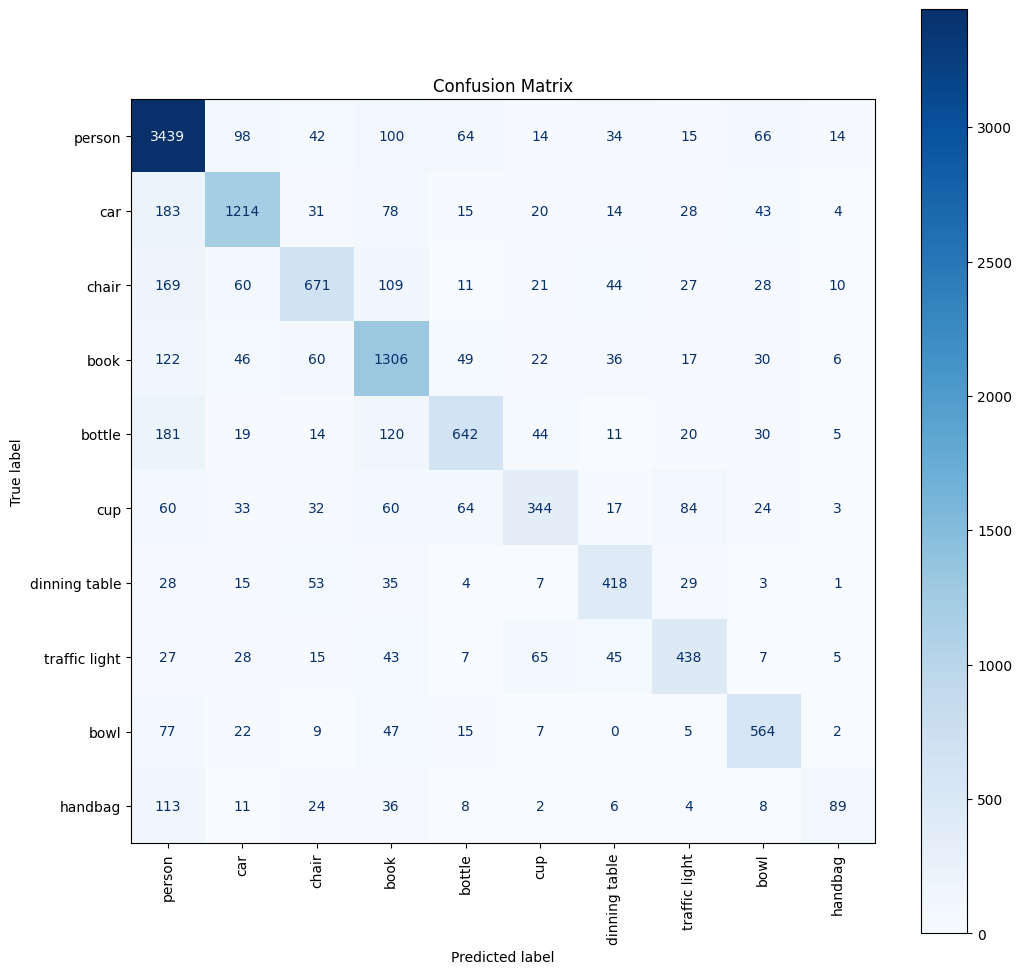

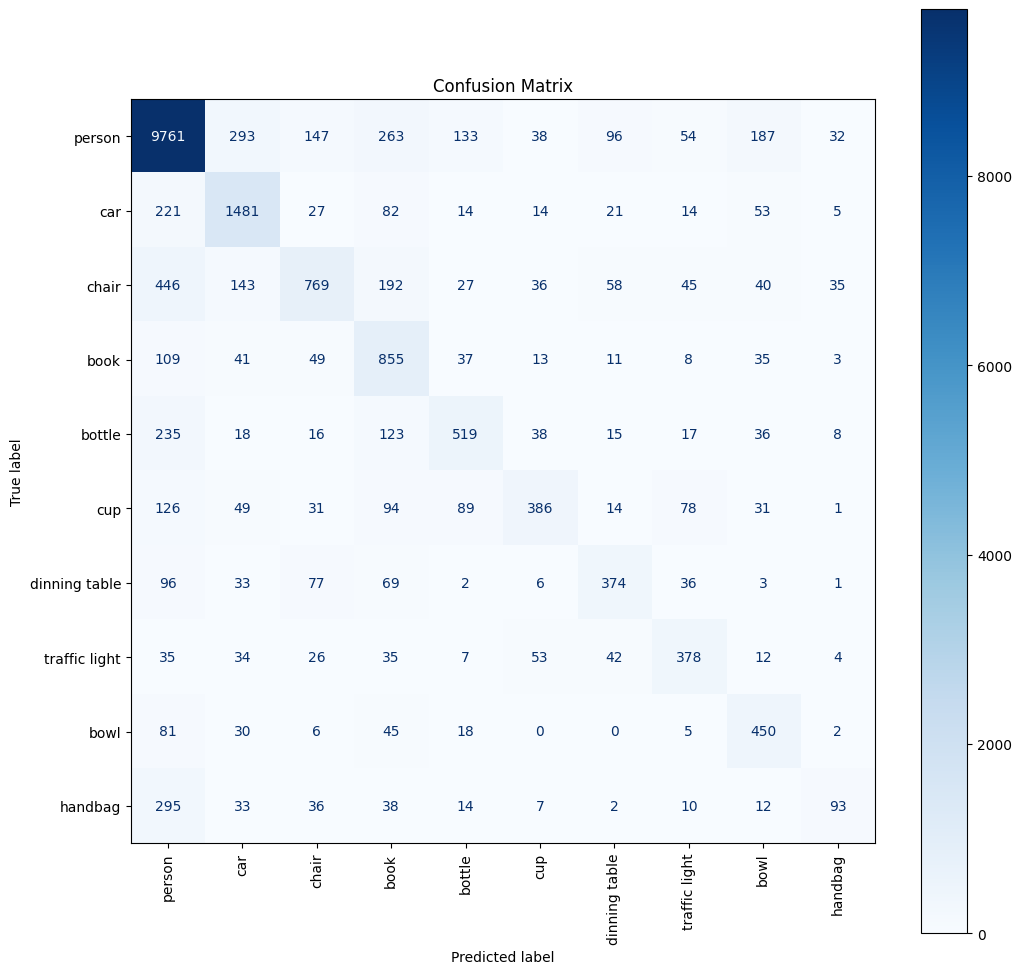

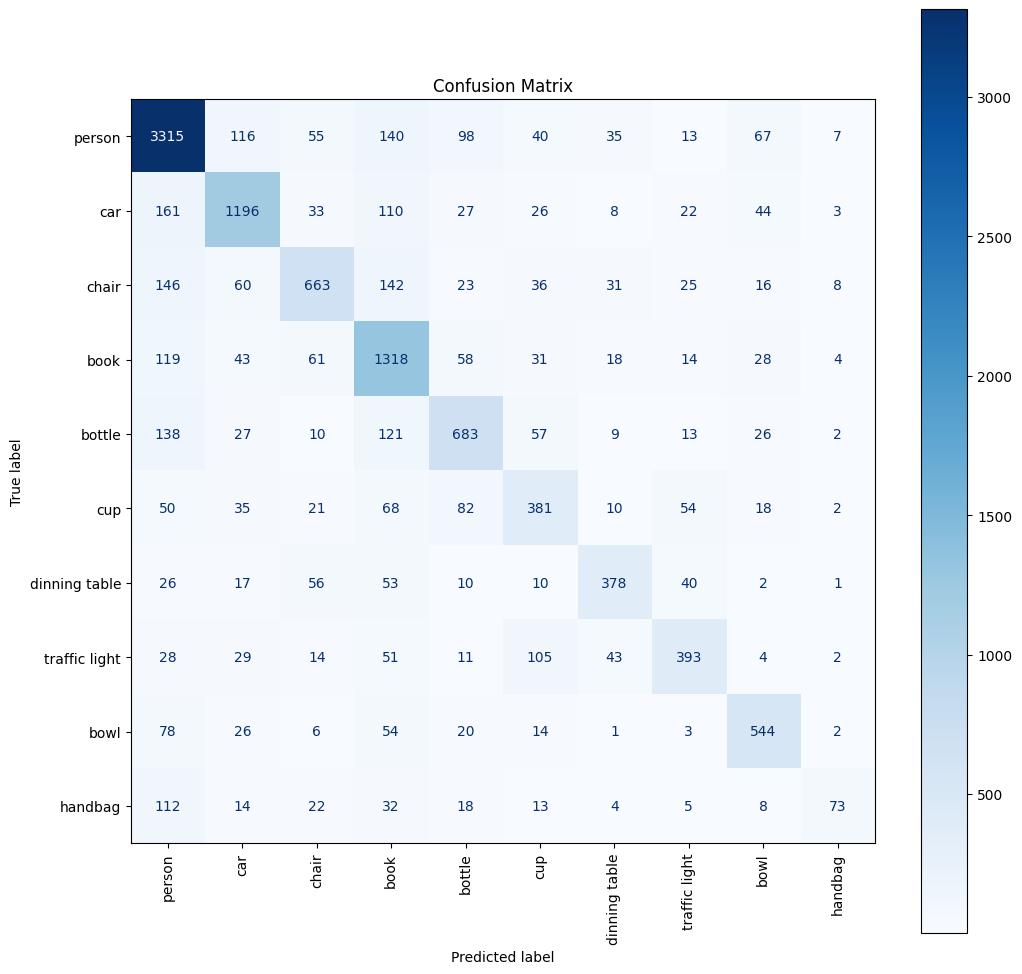

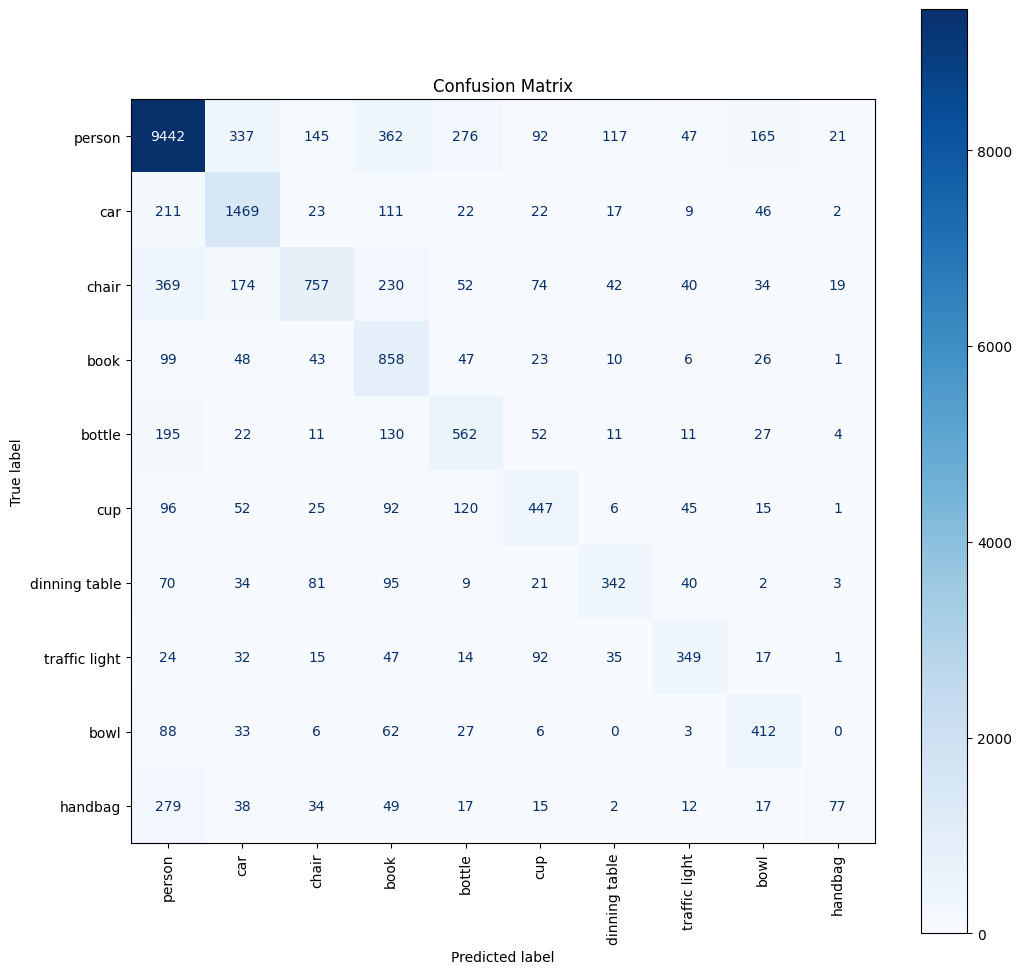

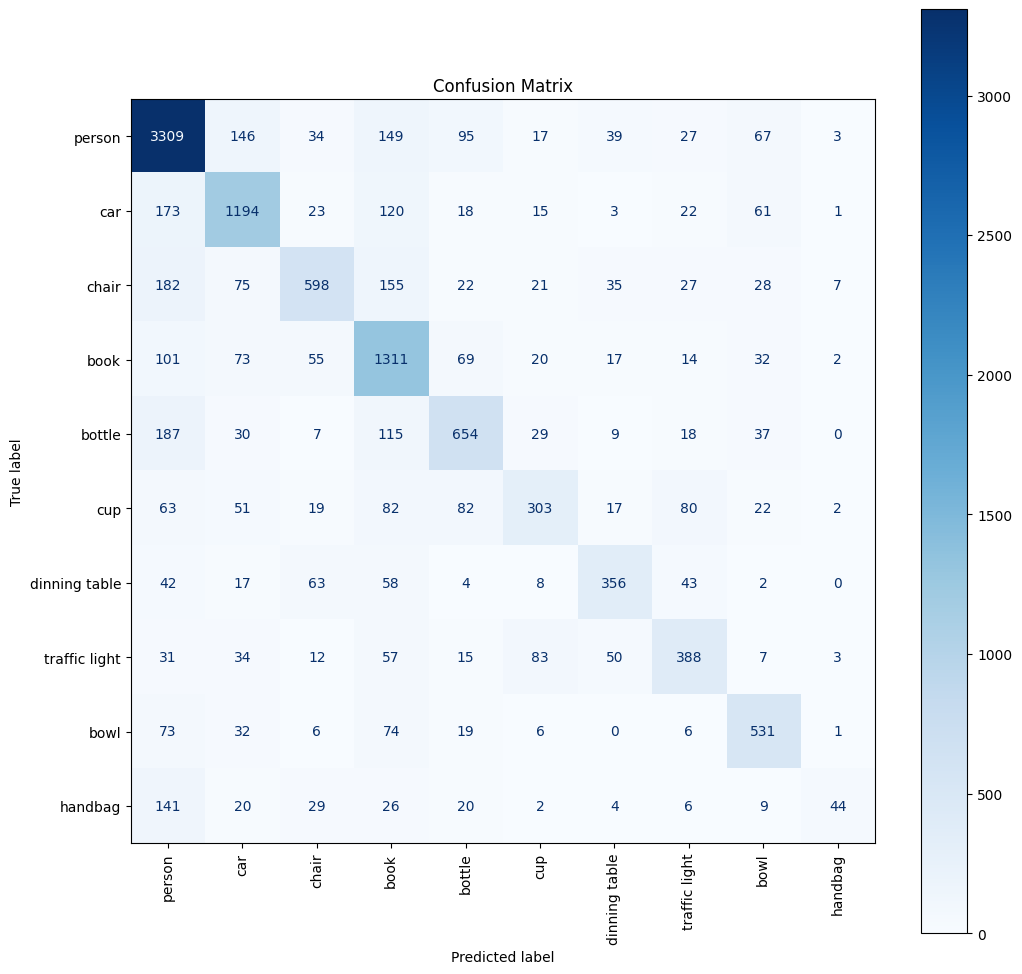

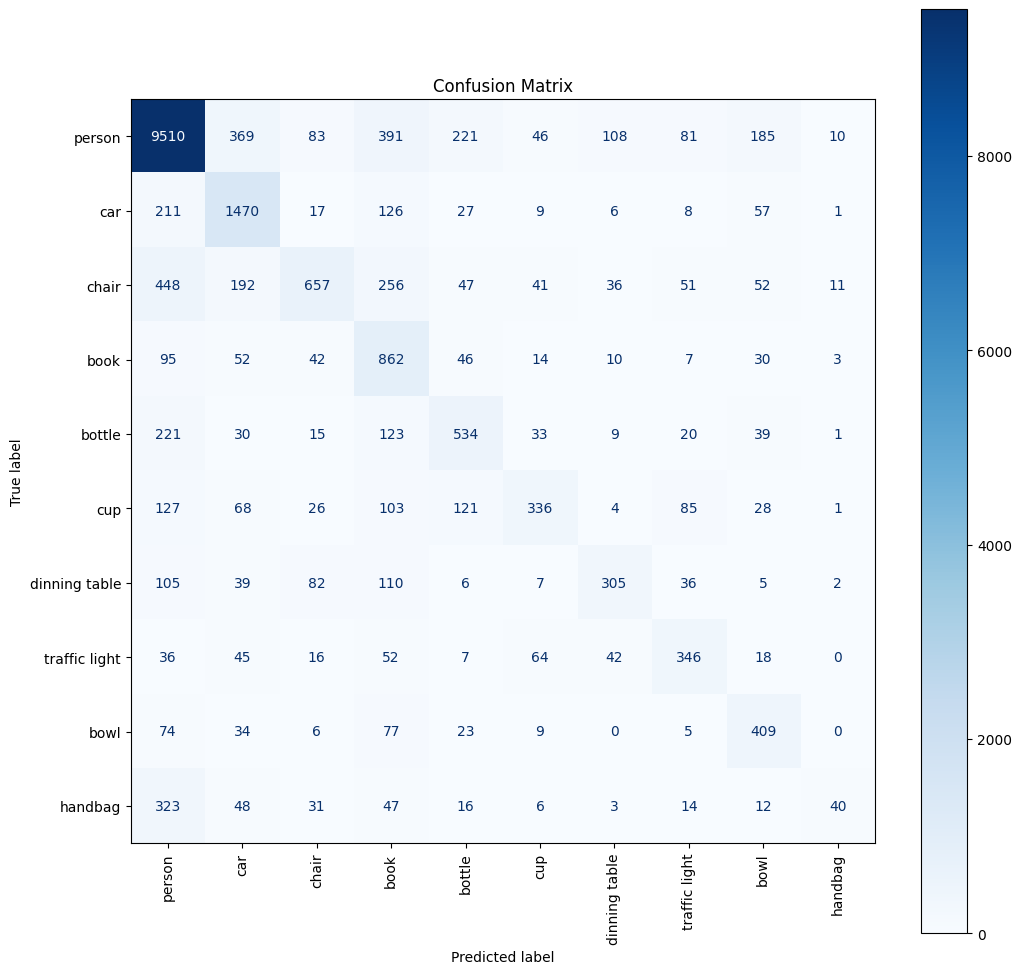

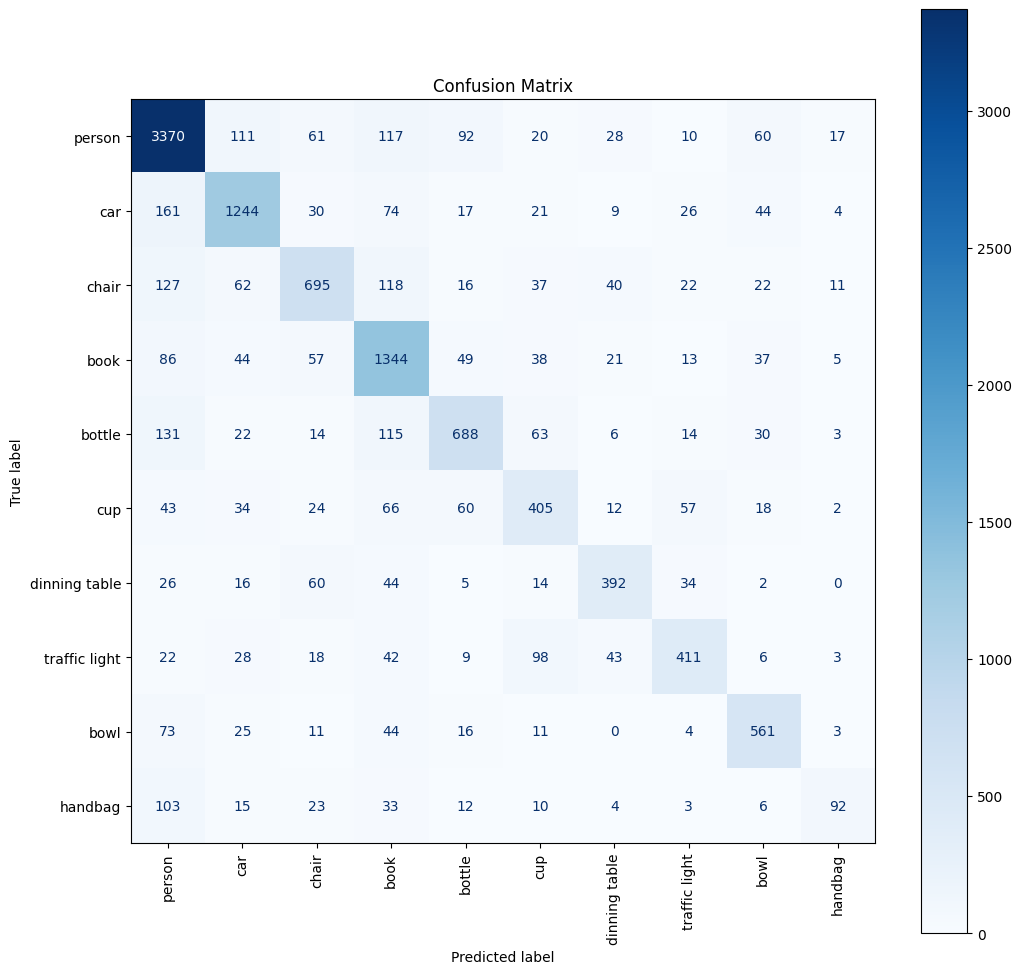

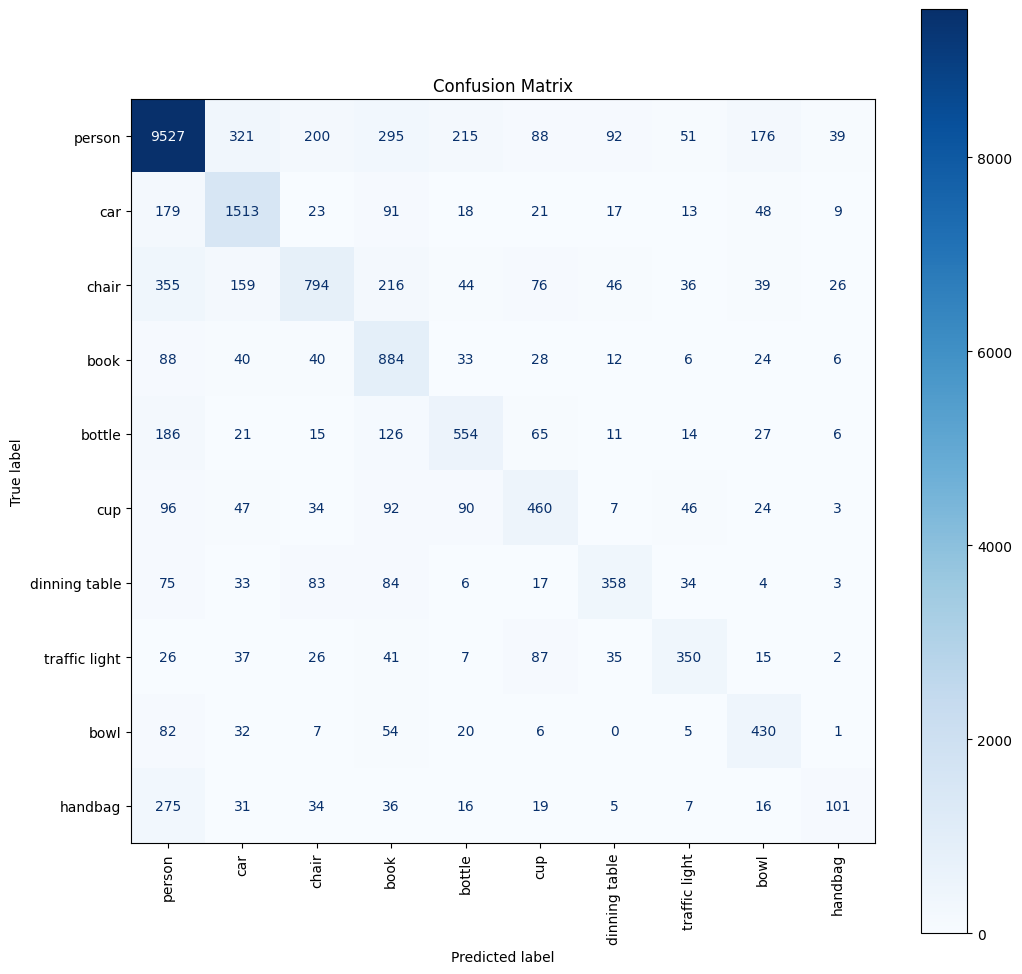

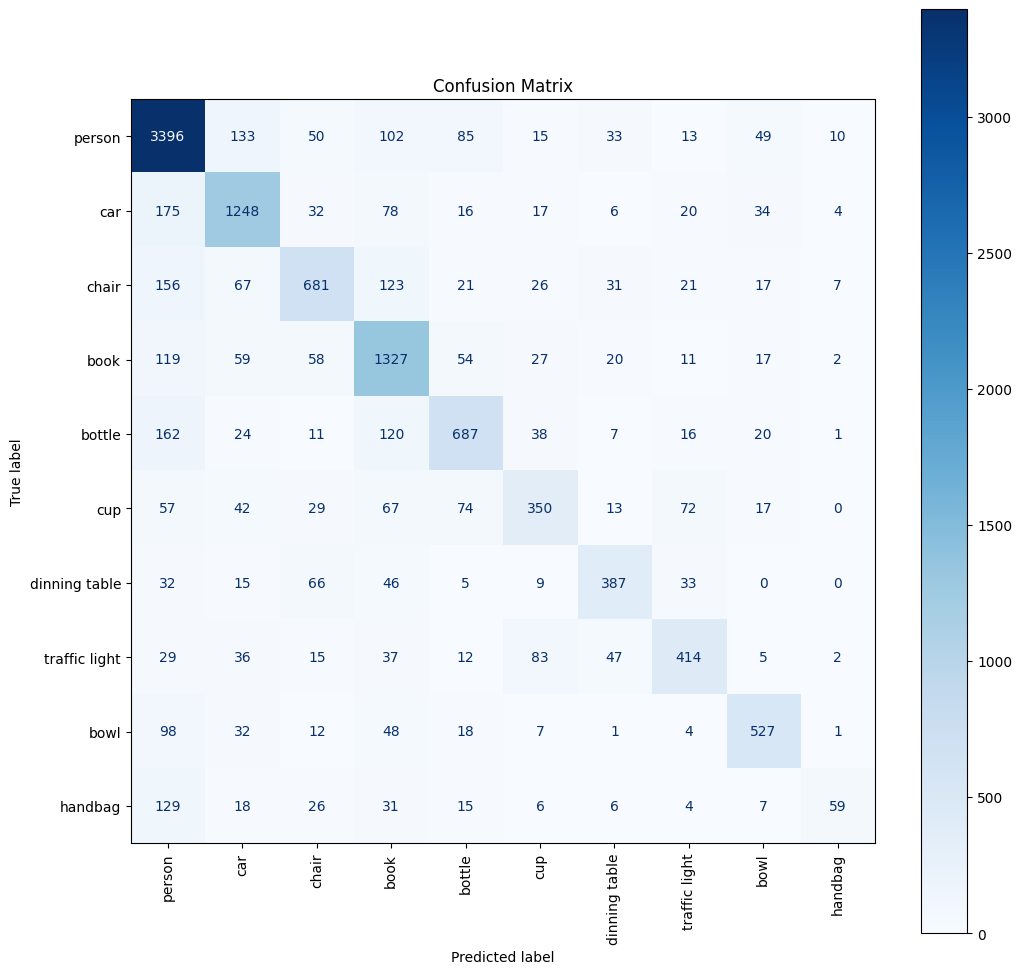

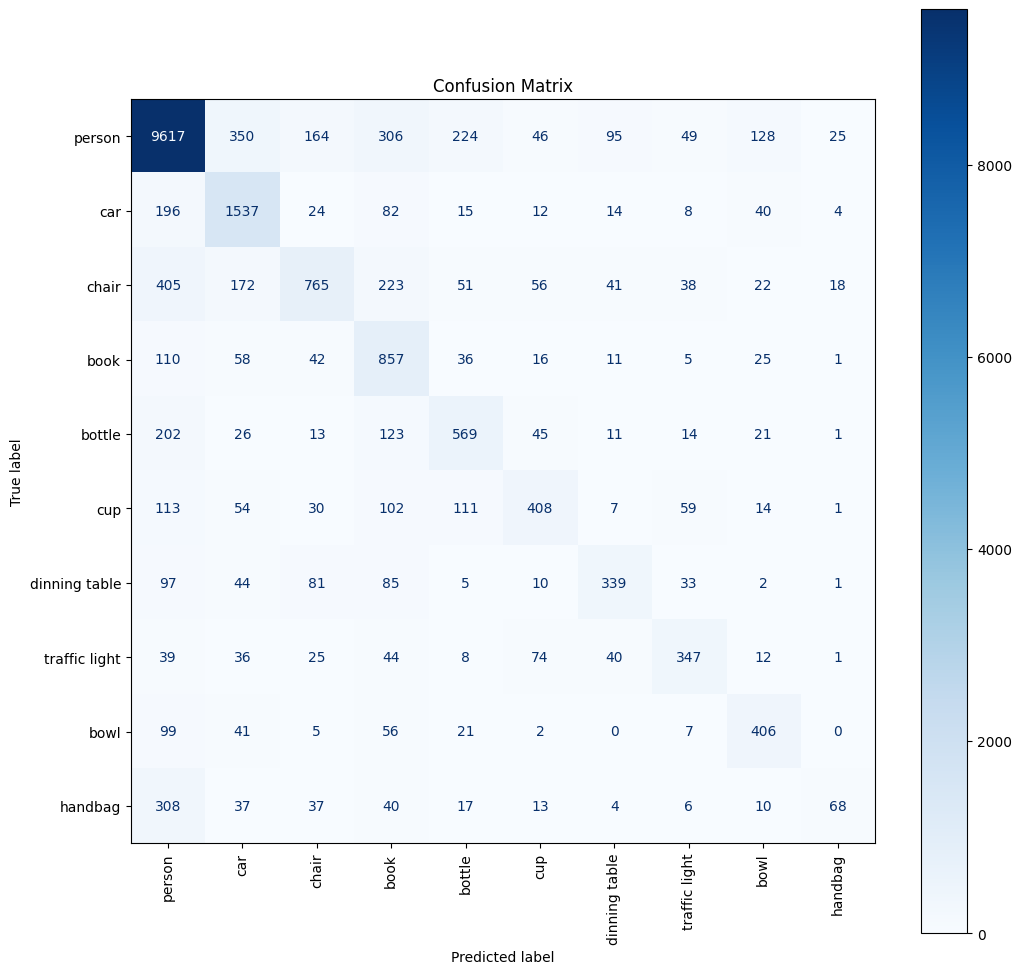

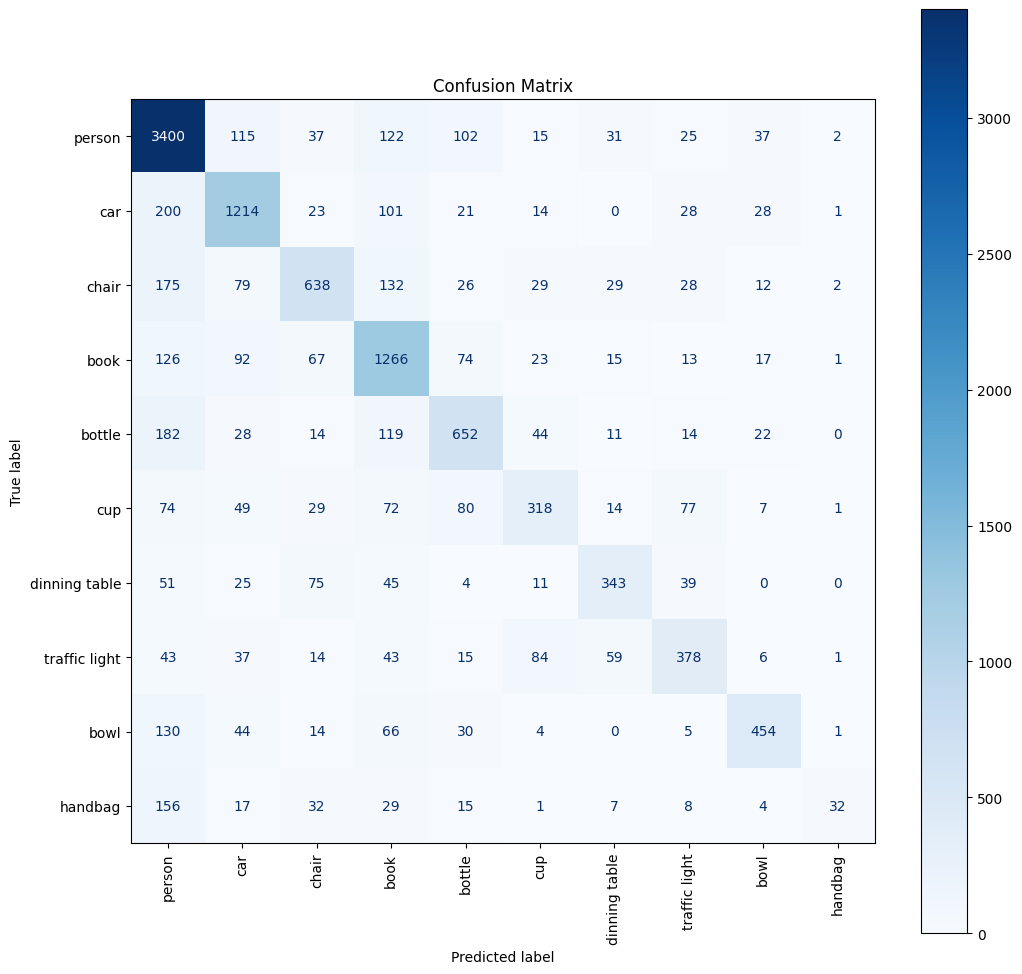

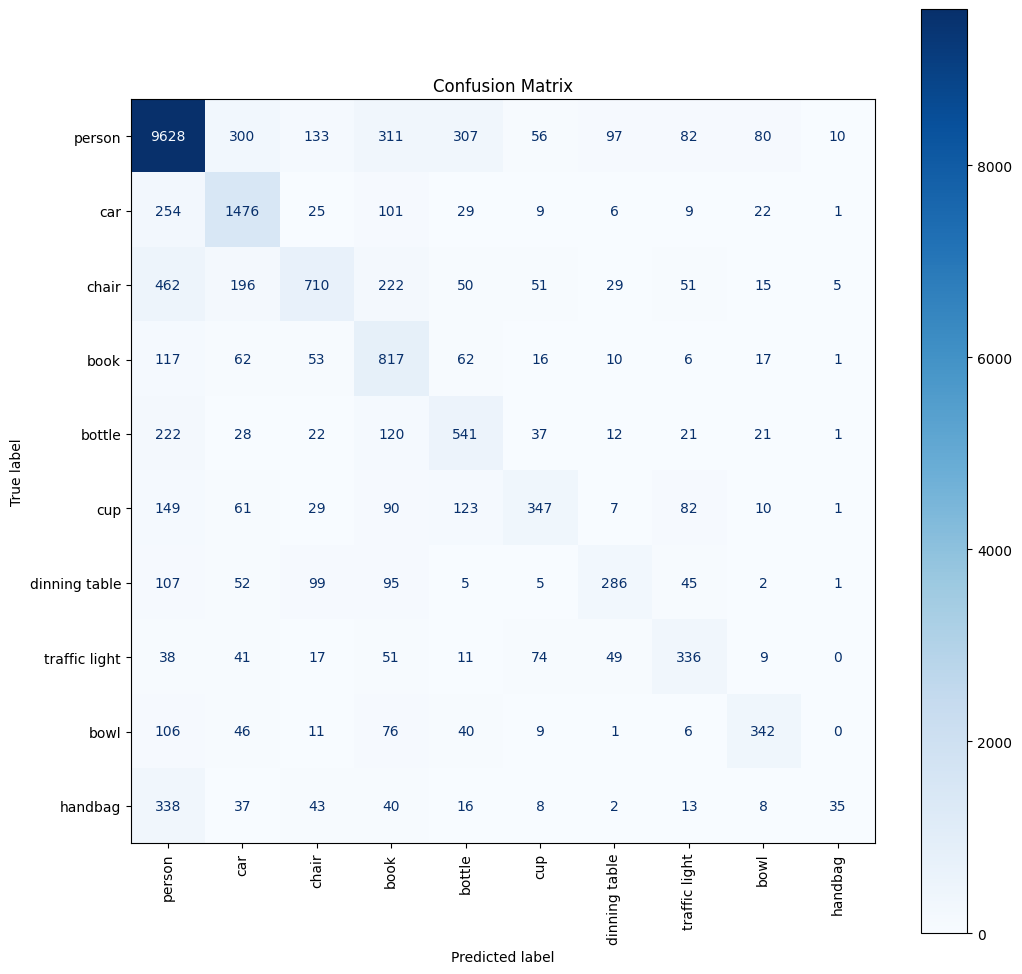

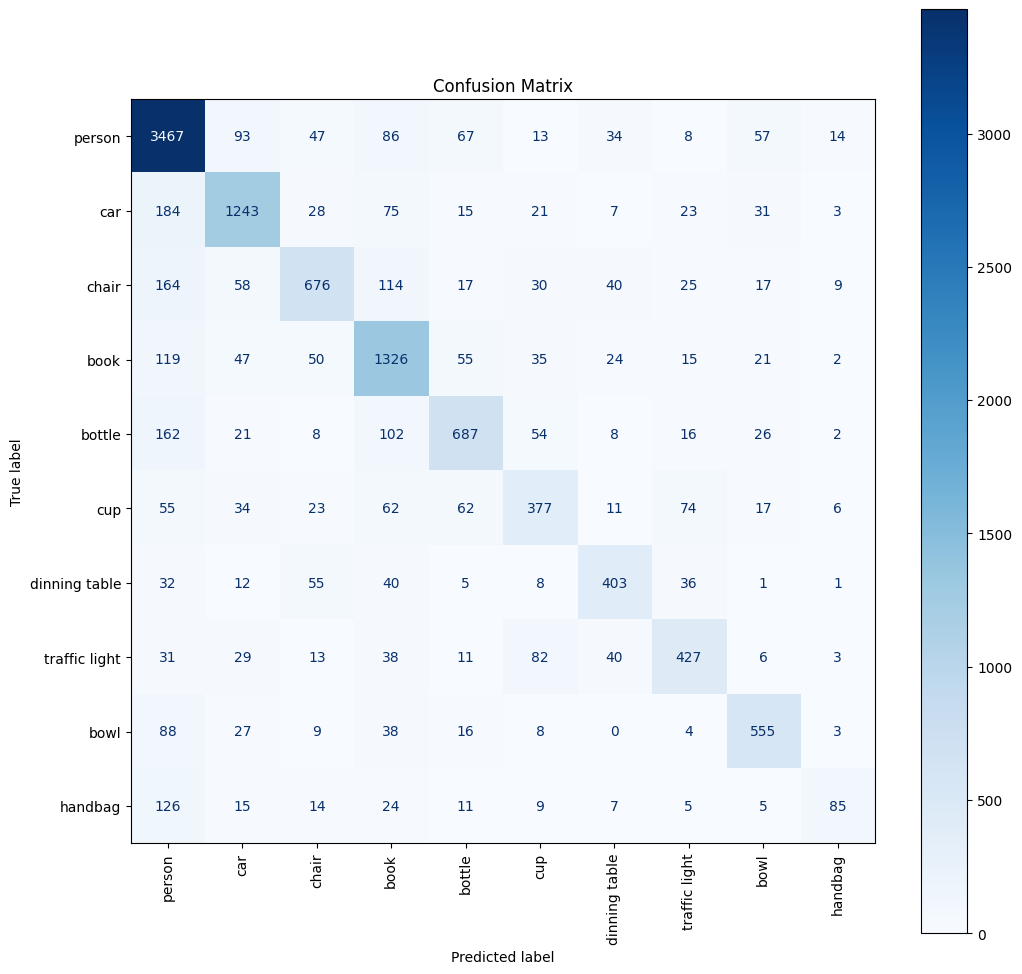

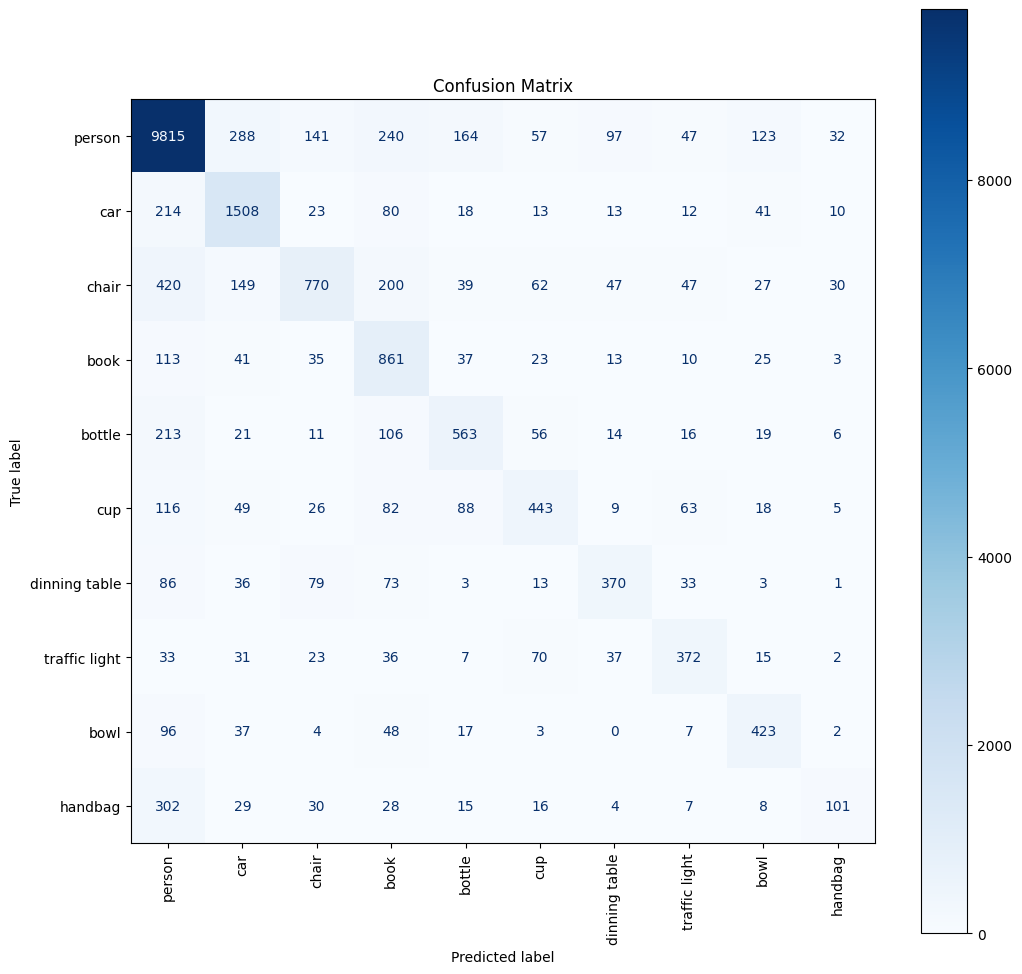

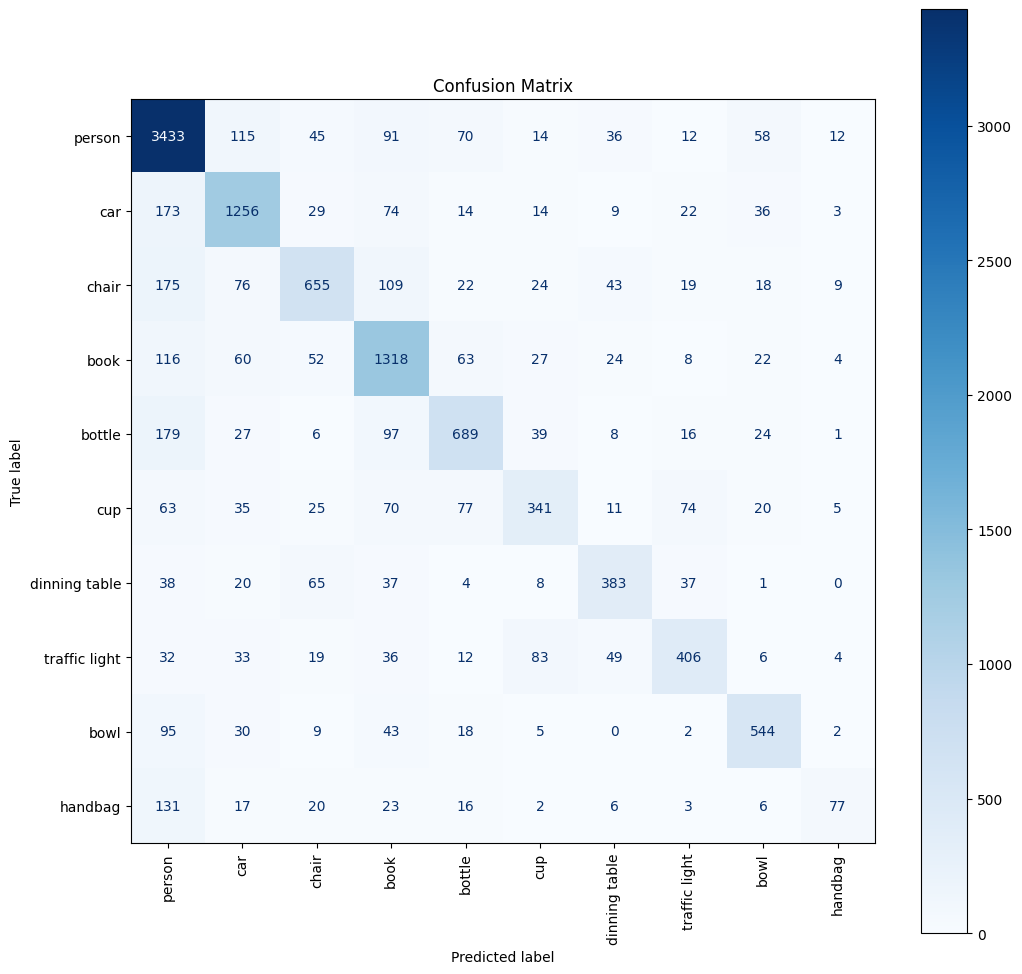

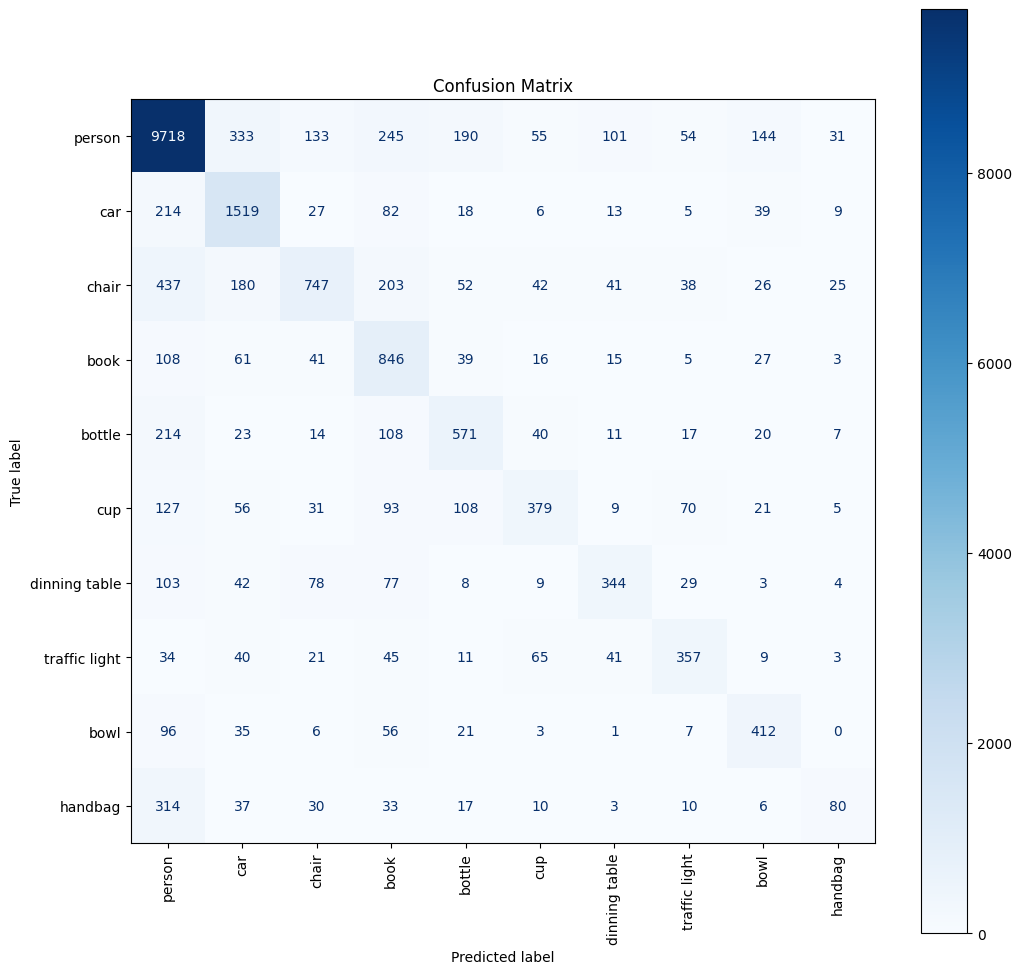

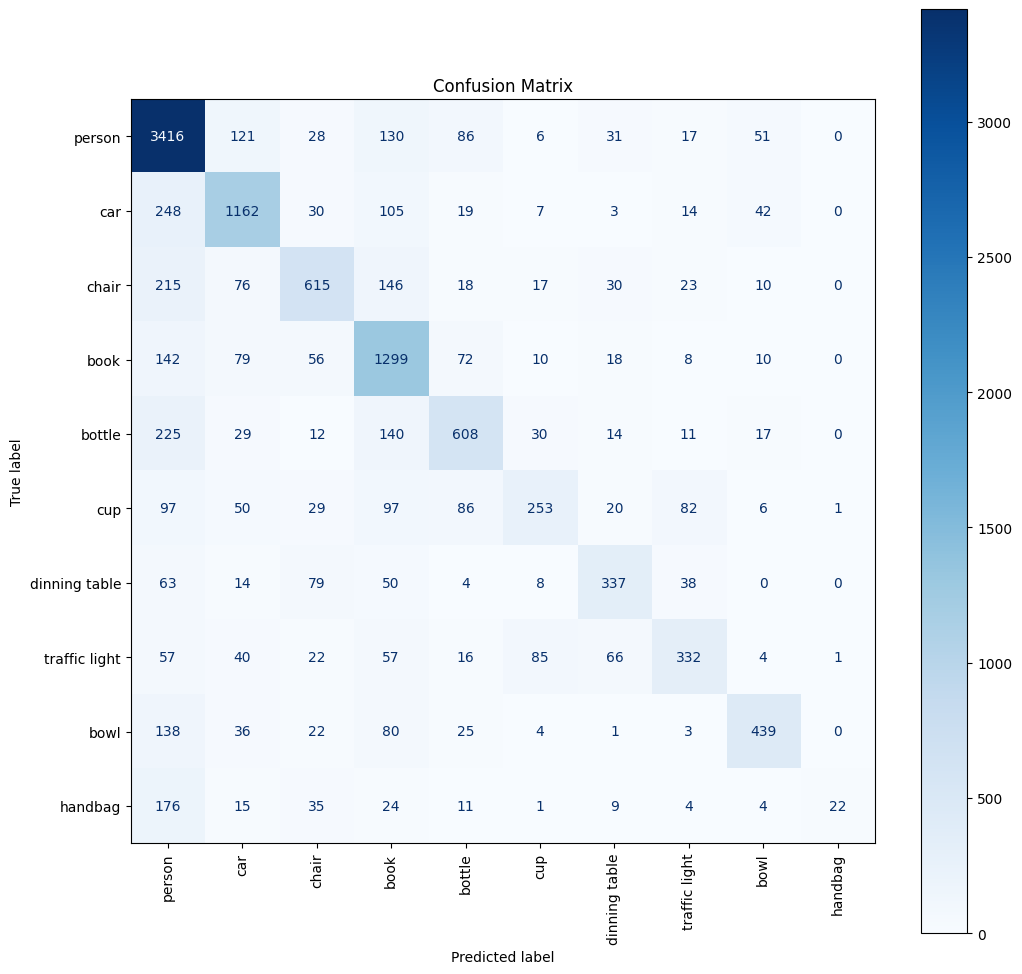

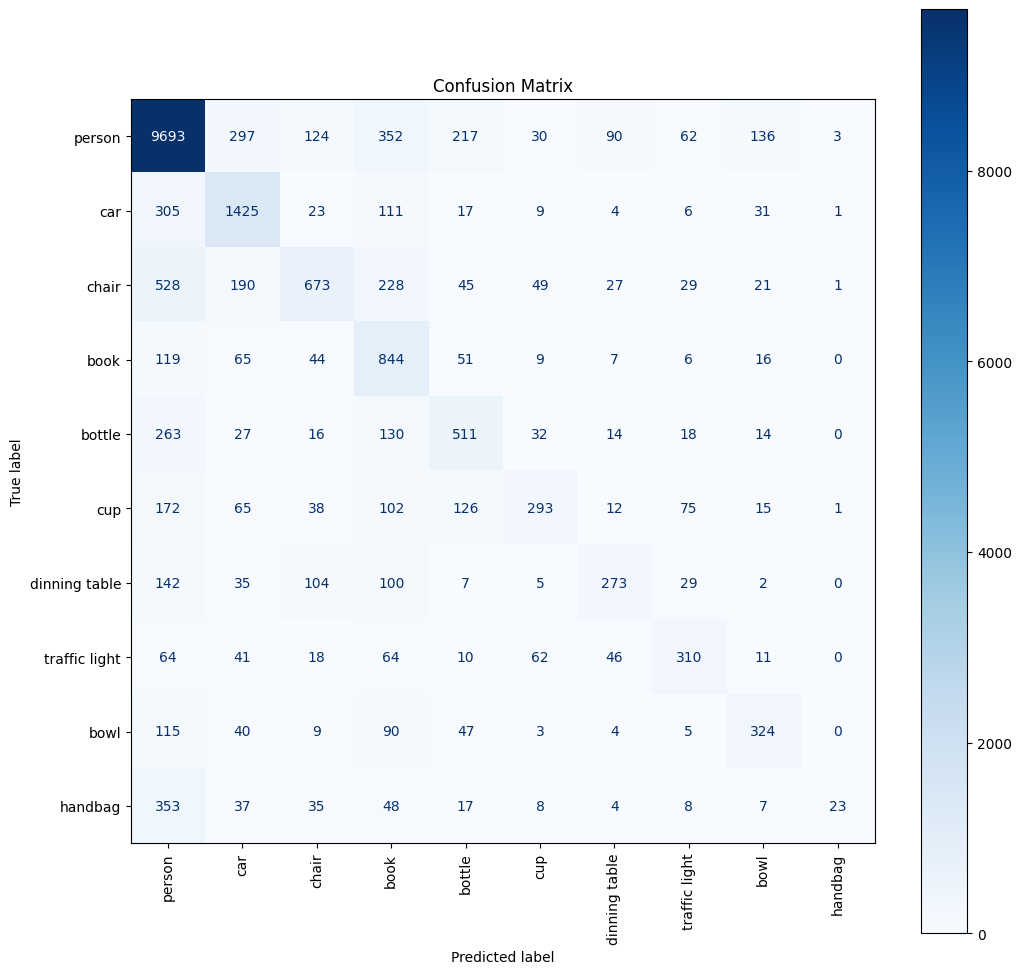

In [32]:
for batch_size, lr in hyperparam_combs:
    print_log(f'-' * 50)
    print_log(f"Batch size: {batch_size}, Learning rate: {lr}")
    print_log(f'-' * 50)

    model_dir = top_model_dir/f'bs_{batch_size}_lr_{lr}'
    if not model_dir.exists():
        model_dir.mkdir(parents=True)
        print_log(f"Model directory {model_dir} created")
    
    model_name = f"{MODEL_NAME}_bs_{batch_size}_lr_{lr}"

    if Path(model_dir/model_name).exists():
        print_log(f"Model {model_dir/model_name} already exists, skipping...")
        continue
    
    # create dataloaders
    data_loader_train, data_loader_test, data_loader_valid = build_data_loaders(batch_size)

    # init model
    model = init_model(FINETUNING_STRAT, len(LABELS))
    model.to(DEVICE)

    # construct optimizer, learning rate scheduler etc.
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params, lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)       # reduce lr by 0.99 every epoch

    # early stopping
    # we monitor the testing accuracy
    early_stopper = EarlyStopper(patience=5, delta=0.005, minimize=False)

    loss_dict = {'train_loss': [], 'test_loss': []}
    acc_dict = {'train_acc': [], 'test_acc': []}

    # training
    for epoch in range(MAX_EPOCHES):
        model.train()
        print_log(f"Epoch {epoch+1}/{MAX_EPOCHES}")
        train_loss, train_acc, y_labels_train, y_pred_train = train_one_epoch(
            model,
            criterion,
            optimizer,
            data_loader_train,
        )
        loss_dict['train_loss'].append(train_loss)
        acc_dict['train_acc'].append(train_acc)

        lr_scheduler.step()

        model.eval()

        # run on test set for evaluation (get test set loss)
        with torch.no_grad():
            test_loss, test_acc, y_labels_test, y_pred_test = evaluate(
                model,
                criterion,
                data_loader_test,
            )
            loss_dict['test_loss'].append(test_loss)
            acc_dict['test_acc'].append(test_acc)

        early_stop = early_stopper.step(test_acc, epoch, model)

        if early_stop:
            print_log(f"Early stopping at epoch {epoch+1}")
            break

    print_log(f"Best epoch: {early_stopper.best_epoch+1}; Best Acc: {early_stopper.best_loss:.3f}")
    # get the best model
    best_model = early_stopper.get_best_model()
    best_epoch = early_stopper.best_epoch

    # save the best model
    model_name = model_name + f'_epoch_{best_epoch+1}.pth'
    torch.save(best_model.state_dict(), model_dir/model_name)
    print_log(f"Model saved to {model_dir/model_name}")

    # save the loss dict
    loss_dict_path = model_dir/'loss_dict.pkl'
    with open(loss_dict_path, 'wb') as f:
        pickle.dump(loss_dict, f)
    print_log(f"Loss dict saved to {loss_dict_path}")


    # evaluate the model on train, test and validation set
    best_model.eval()

    # train set
    # save_evaluations(y_labels_train, y_pred_train, LABELS, model_dir, eval_stage='train')
    # y_labels_train_path = model_dir / 'y_labels_train.pkl'
    # y_pred_train_path = model_dir / 'y_pred_train.pkl'
    # np.save(y_labels_train_path, y_labels_train)
    # np.save(y_pred_train_path, y_pred_train)

    y_labels_test, y_pred_test = evaluation_pred(best_model, data_loader_test, stage='test')
    save_evaluations(y_labels_test, y_pred_test, LABELS, model_dir, eval_stage='test')
    y_labels_test_path = model_dir / 'y_labels_test.pkl'
    y_pred_test_path = model_dir / 'y_pred_test.pkl'
    np.save(y_labels_test_path, y_labels_test)
    np.save(y_pred_test_path, y_pred_test)

    # save the model predictions
    y_labels_valid, y_pred_valid = evaluation_pred(best_model, data_loader_valid, stage='validation')
    save_evaluations(y_labels_valid, y_pred_valid, LABELS, model_dir, eval_stage='validation')
    y_labels_valid_path = model_dir / 'y_labels_valid.pkl'
    y_pred_valid_path = model_dir / 'y_pred_valid.pkl'
    np.save(y_labels_valid_path, y_labels_valid)
    np.save(y_pred_valid_path, y_pred_valid)

    print_log(f"Finished training for batch size: {batch_size}, learning rate: {lr}")
    print_log(f'-' * 50)

---

Load the pre-trained faster rcnn network

In [ ]:
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# using mobile net for faster training, while have decent accuracy
model = fasterrcnn_mobilenet_v3_large_fpn()

n_classes = len(dataset_traintest.labels)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, n_classes)

In [23]:
from torchinfo import summary

summary(model, input_size=(8, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
FasterRCNN                                              [100, 4]                  --
├─GeneralizedRCNNTransform: 1-1                         [8, 3, 800, 800]          --
├─BackboneWithFPN: 1-2                                  [8, 256, 13, 13]          --
│    └─IntermediateLayerGetter: 2-1                     [8, 960, 25, 25]          --
│    │    └─Conv2dNormActivation: 3-1                   [8, 16, 400, 400]         (432)
│    │    └─InvertedResidual: 3-2                       [8, 16, 400, 400]         (400)
│    │    └─InvertedResidual: 3-3                       [8, 24, 200, 200]         (3,136)
│    │    └─InvertedResidual: 3-4                       [8, 24, 200, 200]         (4,104)
│    │    └─InvertedResidual: 3-5                       [8, 40, 100, 100]         (9,960)
│    │    └─InvertedResidual: 3-6                       [8, 40, 100, 100]         (20,432)
│    │    └─InvertedResidual: 3-7

Training

In [24]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
from sklearn.model_selection import train_test_split

BATCH_SIZE = 2

def collate_fn(batch):
  return tuple(zip(*batch))


dataset_train = torch.utils.data.Subset(dataset_traintest, train_indices)
dataset_test = torch.utils.data.Subset(dataset_traintest, test_indices)
# create data loaders
data_loader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn,
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn,
)

data_loader_valid = torch.utils.data.DataLoader(
    dataset_val,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn,
)

In [26]:
len(data_loader_train.dataset), len(data_loader_test.dataset), len(data_loader_valid.dataset)

(12674, 3169, 3559)

In [27]:
model.load_state_dict(torch.load('best_model.pth', weights_only=True))

<All keys matched successfully>

In [28]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [29]:
N_EPOCHS = 3

# construct optimizer
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.AdamW(params, lr=5e-3)
# following the tutorial first. Not sure if this is the best optimizer
optimizer = torch.optim.SGD(params, lr=0.001,
                        momentum=0.9,
                        weight_decay=0.0005)

# construct learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=N_EPOCHS, gamma=0.5)

In [30]:
from tqdm import tqdm
import matplotlib.pyplot as plt

'''
Function to train the model over one epoch.
'''
def train_one_epoch(model, optimizer, data_loader, device):
  train_loss_list = []

  tqdm_bar = tqdm(data_loader, total=len(data_loader))
  for idx, data in enumerate(tqdm_bar):
    optimizer.zero_grad()
    images, targets = data

    # print(targets)

    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  # targets = {'boxes'=tensor, 'labels'=tensor}

    losses = model(images, targets)

    loss = sum(loss for loss in losses.values())
    loss_val = loss.item()
    train_loss_list.append(loss.detach().cpu().numpy())

    loss.backward()
    optimizer.step()

    tqdm_bar.set_description(desc=f"Training Loss: {loss_val:.3f}")

  return train_loss_list

In [31]:
'''
Function to validate the model

The losses output will be a dictionary with the following keys (and sample values):
{'loss_classifier': tensor(0.1611, device='cuda:0', grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.1033, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.1994, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0580, device='cuda:0', grad_fn=<DivBackward0>)}
'''

def evaluate(model, data_loader_test, device):
    val_loss_list = []

    tqdm_bar = tqdm(data_loader_test, total=len(data_loader_test))

    for i, data in enumerate(tqdm_bar):
        images, targets = data

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            losses = model(images, targets)

        loss = sum(loss for loss in losses.values())
        loss_val = loss.item()
        val_loss_list.append(loss_val)

        tqdm_bar.set_description(desc=f"Testing Loss: {loss:.4f}")
    return val_loss_list


In [32]:
'''
Function to plot training and valdiation losses and save them in `output_dir'
'''
def plot_loss(train_loss, valid_loss):
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()

    train_ax.plot(train_loss, color='blue')
    train_ax.set_xlabel('Iteration')
    train_ax.set_ylabel('Training Loss')

    valid_ax.plot(valid_loss, color='red')
    valid_ax.set_xlabel('Iteration')
    valid_ax.set_ylabel('Validation loss')

    # figure_1.savefig(f"{OUTPUT_DIR}/train_loss.png")
    # figure_2.savefig(f"{OUTPUT_DIR}/valid_loss.png")

In [32]:
from tqdm import tqdm

loss_dict = {'train_loss': [], 'test_loss': []}
best_model = None

for epoch in range(N_EPOCHS):
    print("----------Epoch {}----------".format(epoch+1))

    # Train the model for one epoch
    train_loss_list = train_one_epoch(model, optimizer, data_loader_train, device)
    loss_dict['train_loss'].extend(train_loss_list)

    lr_scheduler.step()

    # Run evaluation to get losses
    test_loss_list = evaluate(model, data_loader_test, device)
    loss_dict['test_loss'].extend(test_loss_list)

    # store the best model
    if best_model is None or min(test_loss_list) < min(loss_dict['test_loss']):
        best_model = model.state_dict()

    break

    # Svae the model ckpt after every epoch
    # ckpt_file_name = f"{OUTPUT_DIR}/epoch_{epoch+1}_model.pth"
    # torch.save({
    #     'epoch': epoch+1,
    #     'model_state_dict': model.state_dict(),
    #     'optimizer_state_dict': optimizer.state_dict(),
    #     'loss_dict': loss_dict
    # }, ckpt_file_name)


----------Epoch 1----------


Testing Loss: 0.1891: 100%|██████████| 1585/1585 [00:43<00:00, 36.24it/s]


In [33]:
# save the best model
torch.save(best_model, "best_model.pth")

In [53]:
_img, _target = dataset_val[0]

In [60]:
_target

{'boxes': tensor([[250.8200, 168.2600, 320.9300, 233.1400],
         [435.3500, 294.2300, 448.8100, 302.0400],
         [447.4400, 293.9100, 459.6000, 301.5600],
         [460.5900, 291.7100, 473.3400, 300.1600],
         [407.0700, 287.2500, 419.7200, 297.1100],
         [618.0600, 289.3100, 629.6600, 297.2600],
         [512.3000, 294.0700, 533.4800, 299.6400],
         [285.5500, 370.5600, 297.6200, 389.7700]]),
 'labels': tensor([1, 2, 2, 2, 2, 2, 2, 1]),
 'area': tensor([4548.7363,  105.1225,   93.0240,  107.7377,  124.7288,   92.2199,
          117.9727,  231.8647]),
 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0]),
 'image_id': tensor([532481])}

In [65]:
model.eval()

# _images = list(image.to(device) for image in images)
_targets = [{k: v.to(device) for k, v in t.items()} for t in [_target]]

prediction = model([_img.to(device)], _targets)

In [66]:
prediction

[{'boxes': tensor([[228.5561, 162.7497, 324.4900, 276.3049],
          [ 60.8669,  42.7334,  97.8022, 129.5400],
          [269.1109, 163.7460, 309.8487, 258.3119],
          [238.0428, 165.0763, 313.6662, 229.2963],
          [ 60.8862,  45.8456,  81.3751, 123.9119],
          [248.5014, 163.1061, 295.5199, 283.9343],
          [ 72.5282,  50.9944,  89.5937, 127.8398],
          [203.8169, 133.1695, 346.3714, 384.7503],
          [ 52.4172,  43.8782, 117.0351,  99.8453],
          [175.4869, 172.9174, 350.4914, 263.5399],
          [ 45.7011,  34.9295, 120.2405, 134.7366],
          [163.5344, 159.9768, 365.1031, 228.9554],
          [260.2890, 150.8506, 333.2132, 360.5005],
          [222.7567, 193.5051, 319.2958, 251.7576],
          [294.0408, 186.9751, 315.8139, 245.1031],
          [  0.0000,  44.0493, 103.7229, 124.7355]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2], device='cuda:0'),
  'scores': tensor

---